## Imports

# Stress Testing

**This code currently is still under development, so for now the results are not the conclusions.**

## Abstract

Financial markets are unpredictable, and crises such as the 2008 crash and the COVID-19 downturn have exposed flaws in traditional risk models. Conventional stress testing methods, such as historical analysis and Monte Carlo simulations, struggle to anticipate new and unprecedented crises because of their reliance on past data and simplified assumptions. These methods underestimate fat-tailed risks and fail to model the complex relationships between assets and macroeconomic factors, making them ineffective for real-world risk management.

This project leverages deep generative models-Conditional Variational Autoencoder (cVAE) and Conditional Wasserstein GAN with Gradient Penalty (WGAN-GP), to generate synthetic crisis scenarios based on macroeconomic conditions such as inflation, interest rates, and volatility. Unlike traditional methods, these models dynamically simulate extreme market movements, providing a more adaptive and data-driven approach to stress testing.

The model is applied to Warren Buffett's Q4 2019 portfolio, a well-diversified and extensively studied set of investments. The model assesses risk under conditions similar to the COVID-19 collapse, evaluating how artificial intelligence-generated scenarios compare to actual market disruptions. Key metrics such as Value at Risk (VaR), Expected Shortfall (ES), Earth Mover's Distance (EMD), and Jensen-Shannon Divergence (JSD) quantify the model's ability to capture market extremes. In addition, K-Means clustering in latent space helps to classify different levels of financial risk.

The results aim to show that deep generative models can capture extreme market conditions that traditional models fail to represent. WGAN-GP refines the synthetic scenarios by producing more realistic financial stress conditions, while cVAE enables the generation of conditional scenarios based on macroeconomic trends. In addition, K-Means clustering is applied to the latent space to classify stress scenarios into different levels of risk, identifying potential black swan financial events.

Future work includes optimizing training efficiency and validating performance across multiple financial crises.

## Imports

In [1]:
import os

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
from fredapi import Fred

import keras.saving

import tensorflow as tf
from tensorflow.keras.losses import mse
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, Model, backend as K

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from scipy.stats import wasserstein_distance, ks_2samp, entropy, genpareto, chi2

from tensorflow.keras.callbacks import EarlyStopping

import tensorflow_probability as tfp 

2025-03-09 01:26:02.835688: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 01:26:02.867852: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-03-09 01:26:03.624975: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
folder_name = 'models'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [3]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Using GPU:", tf.config.list_physical_devices('GPU'))

Num GPUs Available: 1
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]#12288)],
        )
        print("GPU memory limited to 8GB")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Running on CPU.")

GPU memory limited to 8GB


In [5]:
SEED_RANDOM = 101
np.random.seed(SEED_RANDOM)
random.seed(SEED_RANDOM)
tf.random.set_seed(SEED_RANDOM)

EPOCHS_GENERATOR = EPOCHS_WGAN = 1000
EPOCHS_CVAE = 500
LATENT_DIM = 5
NOISE_DIM = 2

NUM_SCENARIOS = 10000

In [6]:
import logging
logging.basicConfig(filename="debug.log", level=logging.INFO)

## Data

### Parameters

Tickers: [Warren Buffett's 2019 Q4 portfolio](https://valuesider.com/guru/warren-buffett-berkshire-hathaway/portfolio/2019/4?sort=-percent_portfolio&sells_page=1&page=2).

In [7]:
portfolio_df = pd.read_csv("portfolio.csv")
tickers = portfolio_df["ticker"].tolist()

portfolio_df["weight"] = portfolio_df["weight"] / 100.0
portfolio_weights = portfolio_df["weight"].values

In [8]:
start_date = "2004-01-01"
backtest_date = "2020-02-20"
backtest_end = "2020-05-01"
end_date = "2021-01-01"

# To allow forward fill, download macro data starting 1 year earlier
pre_start_date = (pd.to_datetime(start_date) - pd.DateOffset(years=1)).strftime(
    "%Y-%m-%d"
)

### Download Market Data

In [9]:
# Download market data once (Close prices and Volume)
market_data = yf.download(tickers, start=pre_start_date, end=end_date, progress=False)
market_data

YF.download() has changed argument auto_adjust default to True


Price            Close                                                 \
Ticker            AAPL        AMZN         AXP        BAC        BIIB   
Date                                                                    
2003-01-02    0.222693    0.978500   23.394018  20.762503   34.340000   
2003-01-03    0.224197    1.026000   23.476959  20.633244   33.689999   
2003-01-06    0.224197    1.035000   24.299929  20.929937   34.230000   
2003-01-07    0.223445    1.077500   23.974569  20.962246   34.240002   
2003-01-08    0.218931    1.051000   23.795946  20.877058   33.029999   
...                ...         ...         ...        ...         ...   
2020-12-24  128.905807  158.634506  111.246826  26.996204  248.889999   
2020-12-28  133.516205  164.197998  112.204285  27.149387  244.149994   
2020-12-29  131.738449  166.100006  111.995720  27.041260  243.460007   
2020-12-30  130.615173  164.292496  113.218628  27.014223  243.580002   
2020-12-31  129.609055  162.846497  114.621643  27.311581  244.860001   

Price                                                                 ...  \
Ticker             BK        COST         DVA         GL          GS  ...   
Date                                                                  ...   
2003-01-02  15.763551   19.460585    8.363333  13.479934   50.043804  ...   
2003-01-03  15.869805   18.950766    8.460000  13.487139   50.568325  ...   
2003-01-06  16.663605   19.178843    8.483333  13.703859   52.450794  ...   
2003-01-07  16.588606   19.487429    8.416667  13.544934   52.235252  ...   
2003-01-08  15.938560   19.655138    8.376667  13.508814   50.956310  ...   
...               ...         ...         ...        ...         ...  ...   
2020-12-24  36.113945  346.373871  115.129997  89.607010  230.967072  ...   
2020-12-28  36.465935  352.530304  115.449997  90.012260  234.059769  ...   
2020-12-29  36.465935  354.107422  116.000000  88.921951  232.635147  ...   
2020-12-30  36.685925  355.751007  115.500000  89.935066  233.933502  ...   
2020-12-31  37.345905  357.964600  117.400002  91.623573  237.774506  ...   

Price        Volume                                                         \
Ticker          PNC     SIRI       SPY       SU     TEVA      TRV      UPS   
Date                                                                         
2003-01-02   792500   225260  44516300   864800  6000400   833000  2805000   
2003-01-03  1109100   117150  32222600   757200  4711600   961100  1935500   
2003-01-06  1756200   162380  40984500   718000  7149600  1200300  3052500   
2003-01-07  1597900   641390  38640400   631600  6454800  1441100  2370400   
2003-01-08  1335400   553830  38702200   751200  3277400  1385300  1680900   
...             ...      ...       ...      ...      ...      ...      ...   
2020-12-24   518800   556740  26457900  2079400  3108700   416800  1006100   
2020-12-28  1686800  1497000  39000400  3881700  7786000  1100300  1861700   
2020-12-29  1015400  1752900  53680500  5874800  6494700   859000  2864600   
2020-12-30  1002600  1574270  49455300  4962700  5919500  1253800  3107100   
2020-12-31  1353900  1246820  78520700  4239700  8103700   970200  2349400   

Price                                    
Ticker          USB      VRSN       WFC  
Date                                     
2003-01-02  5131000   6949000   9904200  
2003-01-03  3398700   3147300   7808000  
2003-01-06  6704900   5064200   8097400  
2003-01-07  5067900  10772800   6556200  
2003-01-08  3579900  10515000   8071000  
...             ...       ...       ...  
2020-12-24  1980900    139900  14443700  
2020-12-28  4330800    296500  21658500  
2020-12-29  4083400    287100  19584400  
2020-12-30  3157400    248500  18519300  
2020-12-31  3778500    311100  21081200  

[4532 rows x 150 columns]

In [10]:
close_data = market_data["Close"]
returns_all = np.log(close_data / close_data.shift(1))

# Use returns only from start_date to backtest_date for training
returns_train = returns_all.loc[start_date:backtest_date]
returns_test = returns_all.loc[backtest_date:backtest_end]

# Scale returns
returns_scaler = StandardScaler()
returns_train_scaled = returns_train.copy()
returns_train_scaled.iloc[:] = returns_scaler.fit_transform(returns_train_scaled)

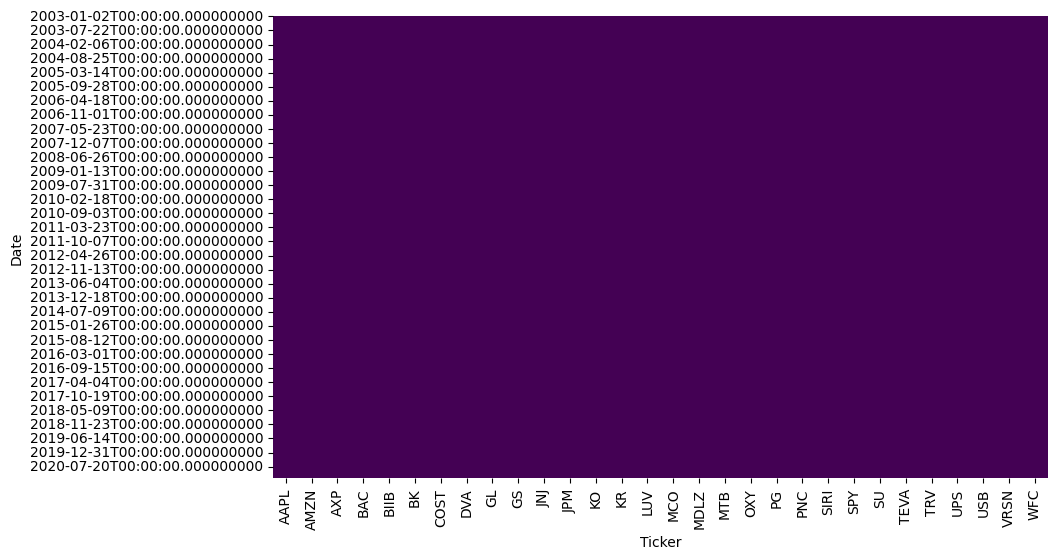

In [11]:
plt.figure(figsize=(10,6))
sns.heatmap(returns_all.isnull(), cmap="viridis", cbar=False)
plt.show()

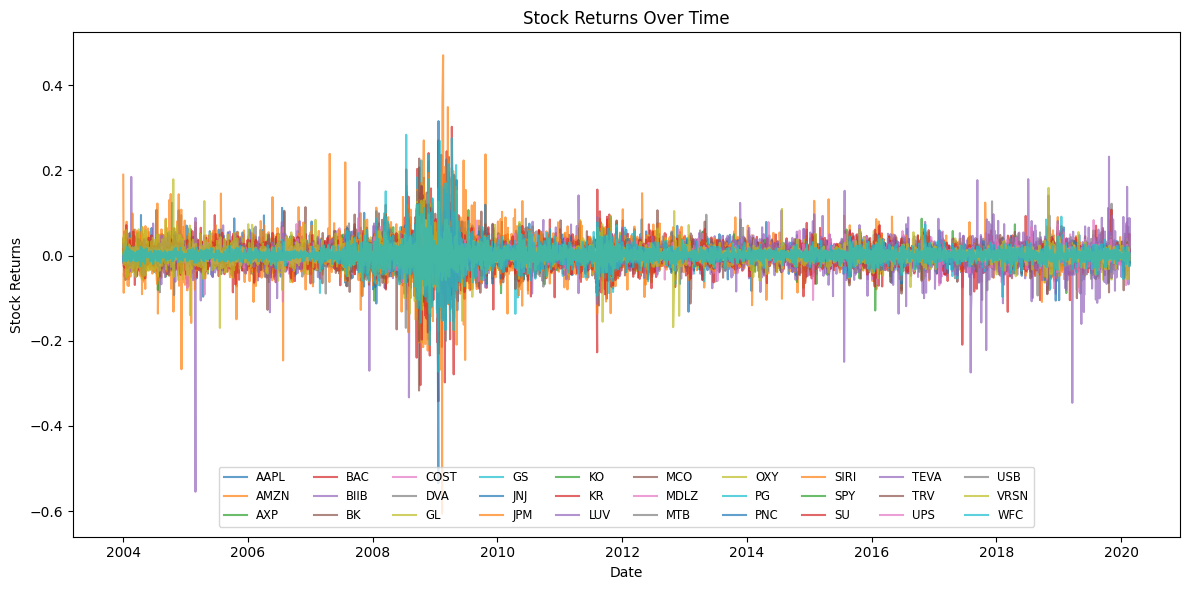

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

for ticker in returns_train.columns:
    ax.plot(returns_train.index, returns_train[ticker], label=ticker, alpha=0.7)

ax.set_xlabel('Date')
ax.set_ylabel('Stock Returns')
plt.title('Stock Returns Over Time')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.15), fontsize='small', ncol=10)
fig.tight_layout()
plt.show()

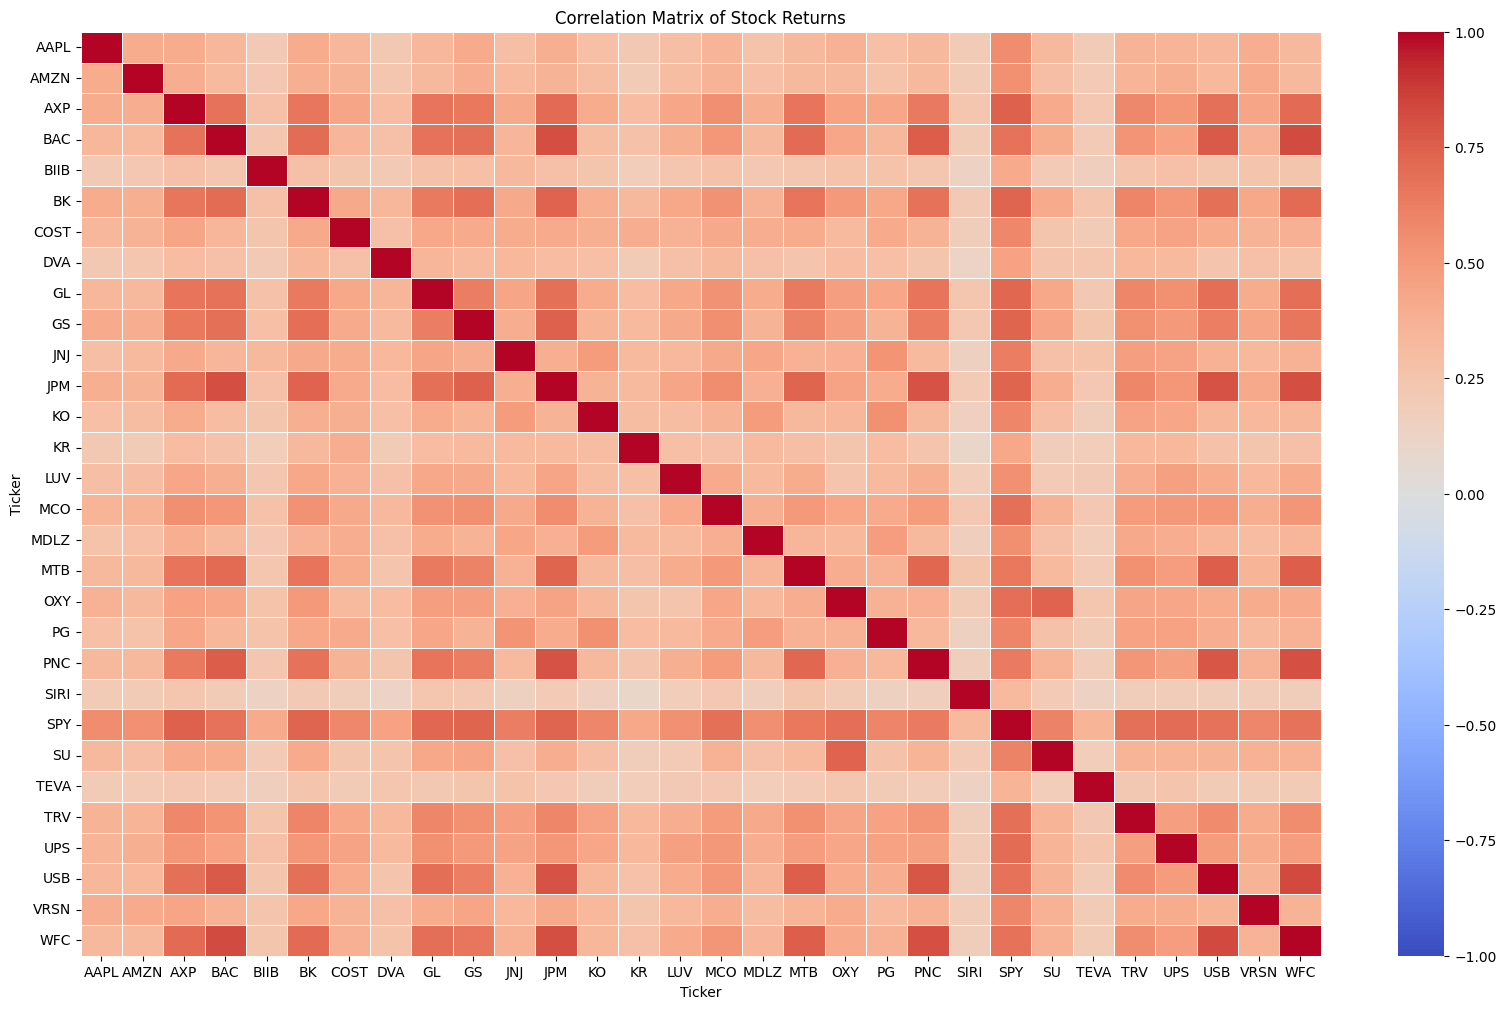

In [13]:
returns_corr_matrix = returns_train.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(returns_corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Stock Returns")
plt.show()

### Download and Prepare Macroeconomic Indicators

In [14]:
with open("key_fred.txt", "r") as file:
    key_fred = file.read().strip()

fred = Fred(api_key=key_fred)

# Download FRED series
inflation = fred.get_series("FPCPITOTLZGUSA")
fed_funds = fred.get_series("FEDFUNDS")
unemployment = fred.get_series("UNRATE")
short_term = fred.get_series("DGS3MO")
long_term = fred.get_series("DGS10")

In [15]:
macro_df = pd.concat(
    [inflation, fed_funds, unemployment, short_term, long_term], axis=1
)
macro_df.ffill(inplace=True)
macro_df.columns = ["inflation", "fed_funds", "unemployment", "short_term", "long_term"]

# VIX
vix_df = yf.download("^VIX", start=pre_start_date, end=end_date, progress=False)
vix_col = "Adj Close" if "Adj Close" in vix_df.columns else "Close"
if isinstance(vix_df.columns, pd.MultiIndex):
    vix_data = vix_df[("Close", "^VIX")].rename("vix")
else:
    vix_data = vix_df["Close"].rename("vix")
macro_df = pd.concat([macro_df, vix_data], axis=1)

# EURUSD exchange rate
fx_df = yf.download("EURUSD=X", start=pre_start_date, end=end_date, progress=False)
if isinstance(fx_df.columns, pd.MultiIndex):
    fx_data = fx_df[("Close", "EURUSD=X")].rename("eurusd")
else:
    fx_data = fx_df["Close"].rename("eurusd")
#macro_df = pd.concat([macro_df, fx_data], axis=1)

# S&P 500 Index
sp500_df = yf.download("^GSPC", start=pre_start_date, end=end_date, progress=False)
sp500_col = "Adj Close" if "Adj Close" in sp500_df.columns else "Close"
if isinstance(sp500_df.columns, pd.MultiIndex):
    sp500_data = sp500_df[("Close", "^GSPC")].rename("sp500")
else:
    sp500_data = sp500_df["Close"].rename("sp500")
returns_sp500 = np.log(sp500_data / sp500_data.shift(1))
returns_sp500_2 = np.log(sp500_data / sp500_data.shift(2)).to_frame(name="returns_sp500_2")
returns_sp500_3 = np.log(sp500_data / sp500_data.shift(3)).to_frame(name="returns_sp500_3")

sp500_roll_min_5 = sp500_data.rolling(window=5, min_periods=1).min().shift(-4)
returns_sp500_5 = np.log(sp500_roll_min_5 / sp500_data).to_frame(name="returns_sp500_roll_5")
returns_sp500_5['returns_sp500_roll_5'] = returns_sp500_5['returns_sp500_roll_5'].apply(lambda x: x if x <= 0 else 0)

macro_df = macro_df.merge(returns_sp500, left_index=True, right_index=True, how="left")
macro_df = macro_df.merge(returns_sp500_5, left_index=True, right_index=True, how="left")

macro_df = macro_df.reindex(returns_all.index)

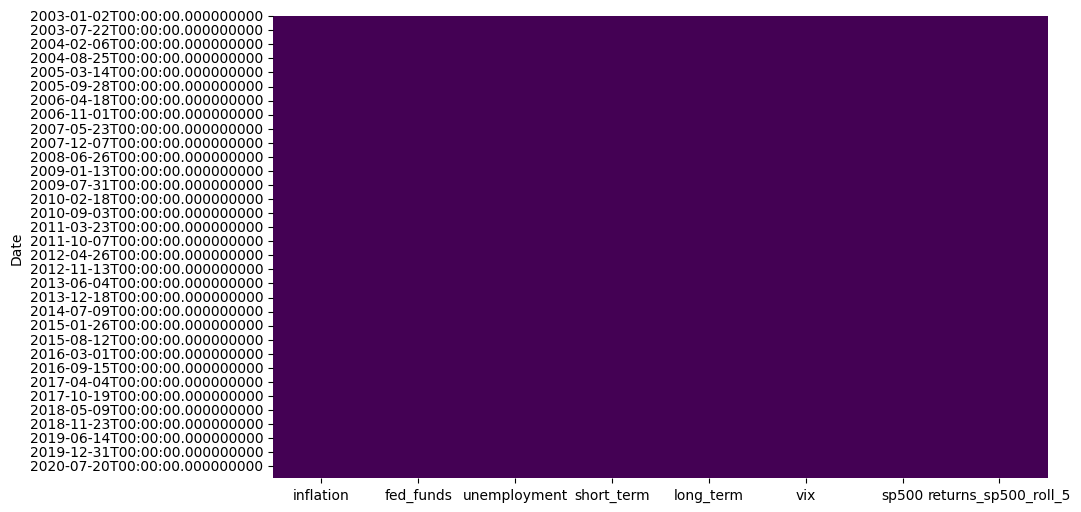

In [16]:
plt.figure(figsize=(10,6))
sns.heatmap(macro_df.isnull(), cmap="viridis", cbar=False)
plt.show()

In [17]:
macro_df_shifted = macro_df.shift(1)
macro_df_shifted = macro_df_shifted.fillna(method="ffill")
macro_df_shifted = macro_df_shifted.loc[start_date:backtest_end]
macro_df_shifted.head()

/tmp/ipykernel_177191/1776427197.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_df_shifted = macro_df_shifted.fillna(method="ffill")


inflation  fed_funds  unemployment  short_term  long_term  \
Date                                                                    
2004-01-02   2.270095       0.98           5.7        0.95       4.27   
2004-01-05   2.677237       1.00           5.7        0.93       4.38   
2004-01-06   2.677237       1.00           5.7        0.91       4.41   
2004-01-07   2.677237       1.00           5.7        0.91       4.29   
2004-01-08   2.677237       1.00           5.7        0.91       4.27   

                  vix     sp500  returns_sp500_roll_5  
Date                                                   
2004-01-02  18.309999  0.002053             -0.003099  
2004-01-05  18.219999 -0.003099              0.000000  
2004-01-06  17.490000  0.012319             -0.000321  
2004-01-07  16.730000  0.001291             -0.001612  
2004-01-08  15.500000  0.002364             -0.004547

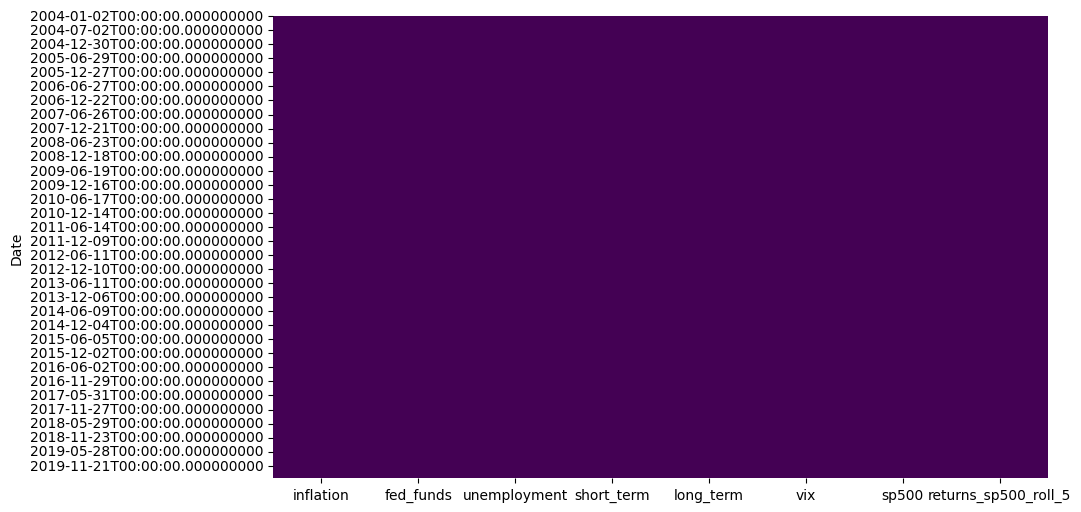

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(macro_df_shifted.isnull(), cmap="viridis", cbar=False)
plt.show()

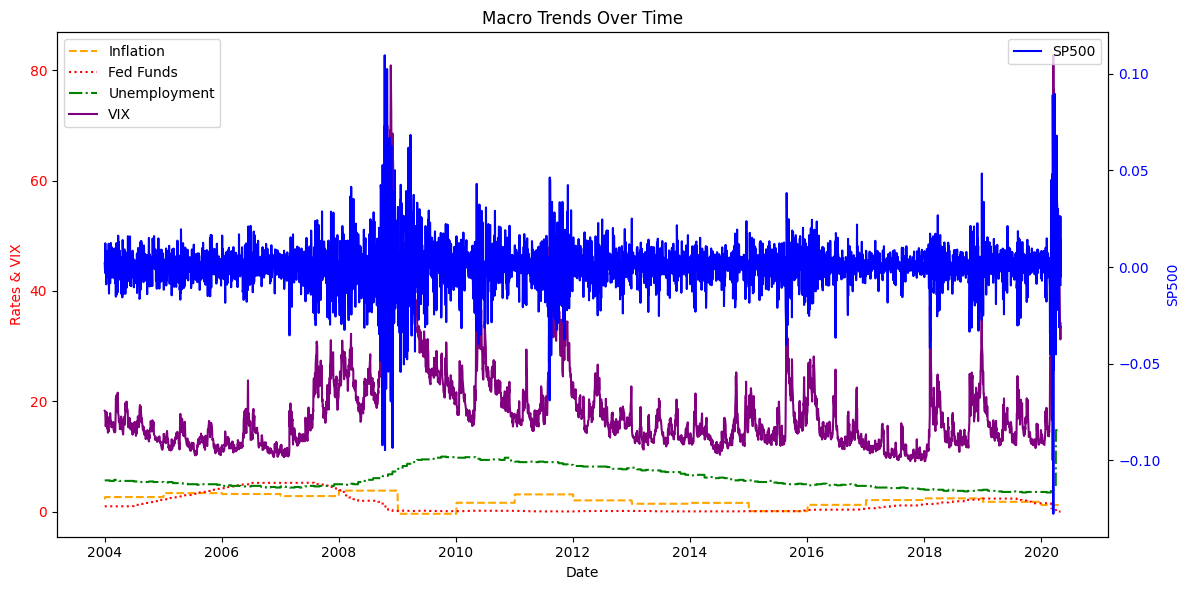

In [19]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y: Plot Inflation, Fed Funds, Unemployment, VIX
ax1.set_xlabel('Date')
ax1.set_ylabel('Rates & VIX', color='red')
ax1.plot(macro_df_shifted.index, macro_df_shifted['inflation'], color='orange', linestyle='dashed', label='Inflation')
ax1.plot(macro_df_shifted.index, macro_df_shifted['fed_funds'], color='red', linestyle='dotted', label='Fed Funds')
ax1.plot(macro_df_shifted.index, macro_df_shifted['unemployment'], color='green', linestyle='dashdot', label='Unemployment')
ax1.plot(macro_df_shifted.index, macro_df_shifted['vix'], color='purple', linestyle='solid', label='VIX')
ax1.tick_params(axis='y', labelcolor='red')

# Right y: Plot SP500
ax2 = ax1.twinx()
ax2.set_ylabel('SP500', color='blue')
ax2.plot(macro_df_shifted.index, macro_df_shifted['sp500'], color='blue', label='SP500')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Macro Trends Over Time')
fig.tight_layout()
plt.show()

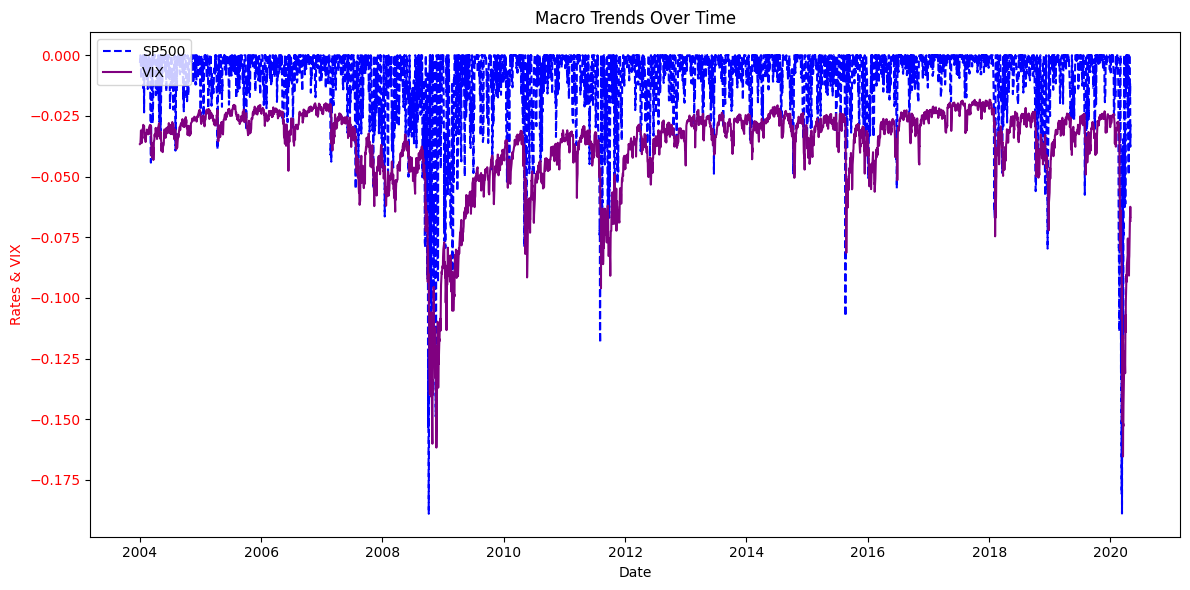

In [20]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y: Plot Inflation, Fed Funds, Unemployment, VIX
ax1.set_xlabel('Date')
ax1.set_ylabel('Rates & VIX', color='red')
ax1.plot(macro_df_shifted.index, macro_df_shifted['returns_sp500_roll_5'], color='blue', linestyle='--', label='SP500')
ax1.plot(macro_df_shifted.index, -macro_df_shifted['vix']/500, color='purple', label='VIX')
ax1.tick_params(axis='y', labelcolor='red')

ax1.legend(loc='upper left')
plt.title('Macro Trends Over Time')
fig.tight_layout()
plt.show()

In [21]:
sp500_col = "Adj Close" if "Adj Close" in sp500_df.columns else "Close"
if isinstance(sp500_df.columns, pd.MultiIndex):
    sp500_data_vt = sp500_df[("Volume", "^GSPC")].rename("Volume")
else:
    sp500_data_vt = sp500_df["Volume"].rename("Volume")

sp500_data_vt = sp500_data_vt.loc[start_date:end_date]

In [22]:
volatility_by_ticker = sp500_data_vt.rolling(window=30).std()
volatility_by_ticker = volatility_by_ticker.loc[start_date:end_date]

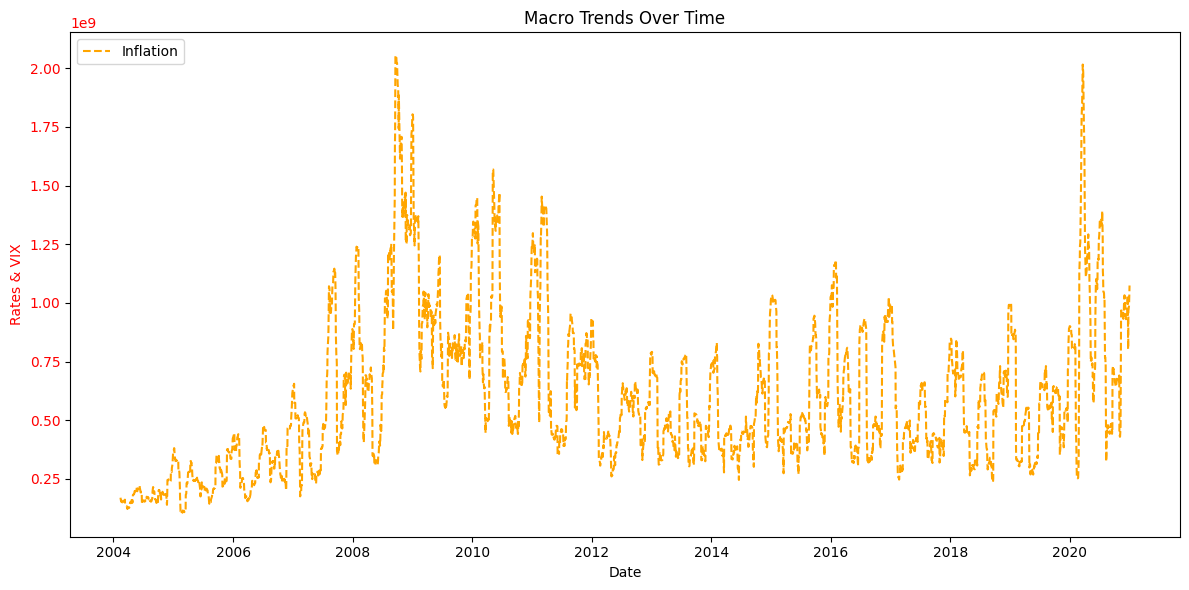

In [23]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y: Plot Inflation, Fed Funds, Unemployment, VIX
ax1.set_xlabel('Date')
ax1.set_ylabel('Rates & VIX', color='red')
ax1.plot(volatility_by_ticker.index, volatility_by_ticker.values, color='orange', linestyle='dashed', label='Inflation')
ax1.tick_params(axis='y', labelcolor='red')

ax1.legend(loc='upper left')
plt.title('Macro Trends Over Time')
fig.tight_layout()
plt.show()

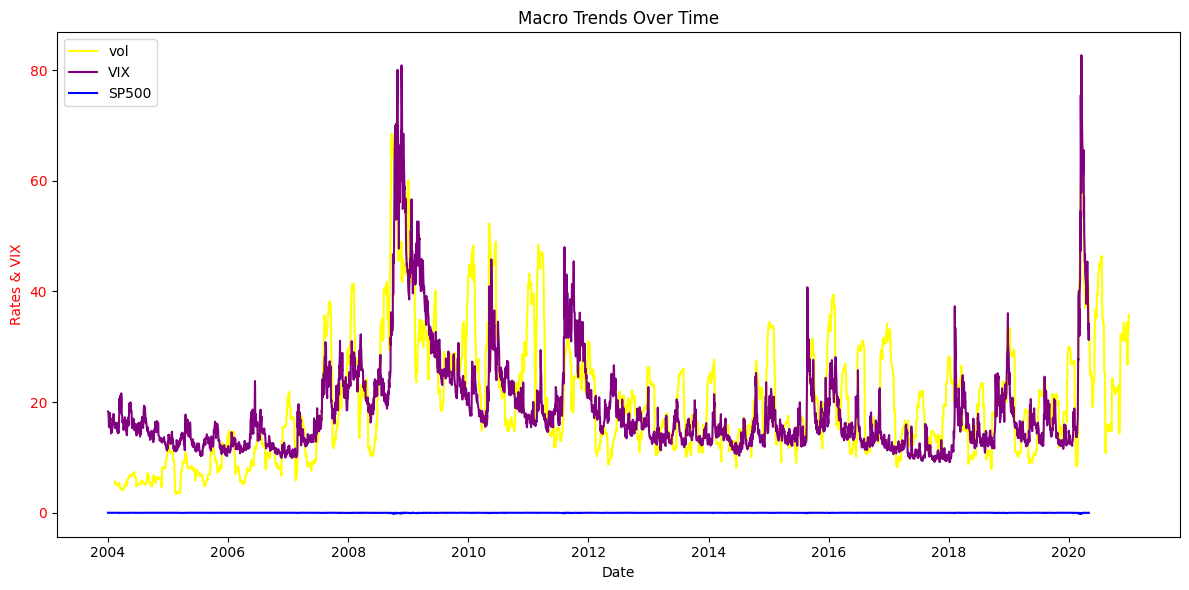

In [24]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y: Plot Inflation, Fed Funds, Unemployment, VIX
ax1.set_xlabel('Date')
ax1.set_ylabel('Rates & VIX', color='red')
ax1.plot(volatility_by_ticker.index, volatility_by_ticker/30000000, color='yellow', linestyle='solid', label='vol')
ax1.plot(macro_df_shifted.index, macro_df_shifted['vix'], color='purple', linestyle='solid', label='VIX')
ax1.plot(macro_df_shifted.index, macro_df_shifted['returns_sp500_roll_5'], color='blue', label='SP500')
ax1.tick_params(axis='y', labelcolor='red')

ax1.legend(loc='upper left')
plt.title('Macro Trends Over Time')
fig.tight_layout()
plt.show()

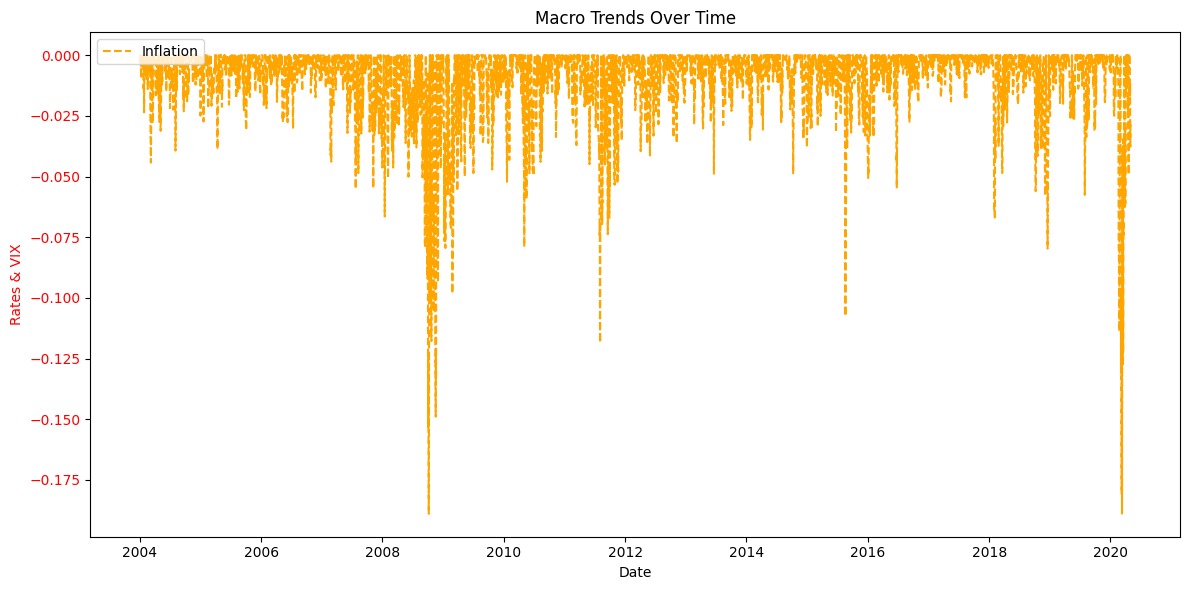

In [25]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y: Plot Inflation, Fed Funds, Unemployment, VIX
ax1.set_xlabel('Date')
ax1.set_ylabel('Rates & VIX', color='red')
ax1.plot(macro_df_shifted.index, macro_df_shifted['returns_sp500_roll_5'], color='orange', linestyle='dashed', label='Inflation')
ax1.tick_params(axis='y', labelcolor='red')

ax1.legend(loc='upper left')
plt.title('Macro Trends Over Time')
fig.tight_layout()
plt.show()

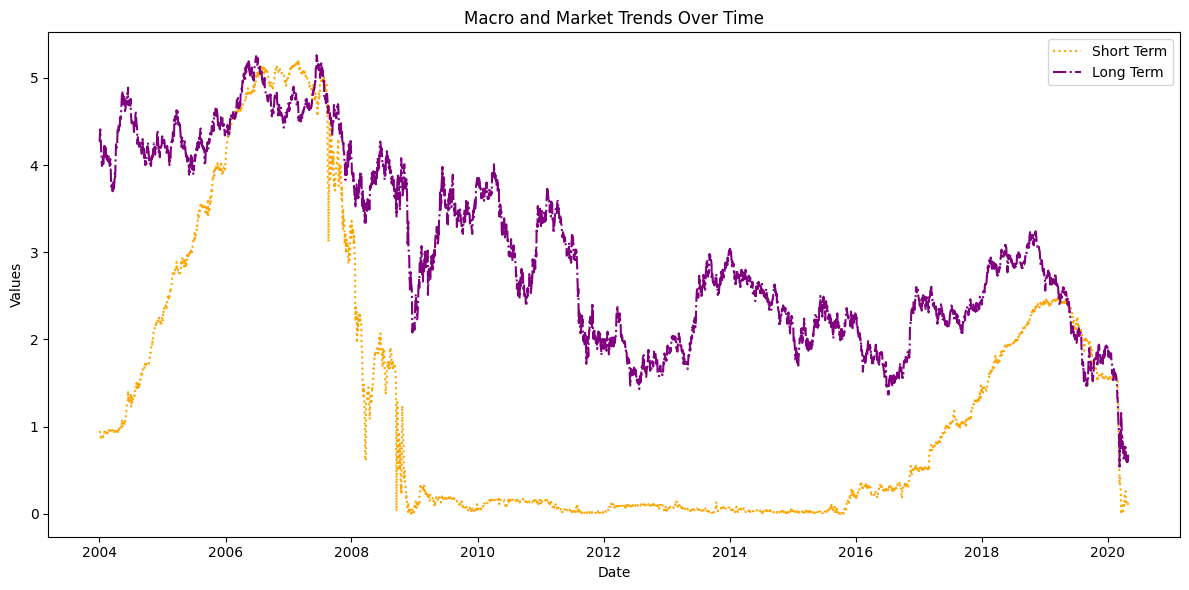

In [26]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Average Volume, EUR/USD, Volatility, Short Term and Long Term on the same axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Values')
#ax1.plot(macro_df_shifted.index, macro_df_shifted['eurusd'], linestyle='dashed', label='EUR/USD', color='green')
ax1.plot(macro_df_shifted.index, macro_df_shifted['short_term'], linestyle='dotted', label='Short Term', color='orange')
ax1.plot(macro_df_shifted.index, macro_df_shifted['long_term'], linestyle='dashdot', label='Long Term', color='purple')
ax1.tick_params(axis='y')

ax1.legend(loc='upper right')
plt.title('Macro and Market Trends Over Time')
fig.tight_layout()
plt.show()

In [27]:
# Calculate volatility for each ticker over a 30-day rolling window
volatility_by_ticker = returns_all.rolling(window=30).std()
volatility_by_ticker = volatility_by_ticker.loc[start_date:end_date]
volatility_by_ticker.columns = [f"vol_{ticker}" for ticker in volatility_by_ticker.columns]

# You can also compute volume for each ticker directly from market_data
volume_by_ticker = market_data["Volume"].loc[start_date:end_date]
volume_by_ticker.columns = [f"volm_{ticker}" for ticker in volume_by_ticker.columns]

# Combine these with your existing macro_df_shifted
input_features = macro_df_shifted.loc[start_date:end_date]#.join(volatility_by_ticker, how='inner')
#input_features = input_features.join(volume_by_ticker, how='inner')

input_features.head()

inflation  fed_funds  unemployment  short_term  long_term  \
Date                                                                    
2004-01-02   2.270095       0.98           5.7        0.95       4.27   
2004-01-05   2.677237       1.00           5.7        0.93       4.38   
2004-01-06   2.677237       1.00           5.7        0.91       4.41   
2004-01-07   2.677237       1.00           5.7        0.91       4.29   
2004-01-08   2.677237       1.00           5.7        0.91       4.27   

                  vix     sp500  returns_sp500_roll_5  
Date                                                   
2004-01-02  18.309999  0.002053             -0.003099  
2004-01-05  18.219999 -0.003099              0.000000  
2004-01-06  17.490000  0.012319             -0.000321  
2004-01-07  16.730000  0.001291             -0.001612  
2004-01-08  15.500000  0.002364             -0.004547

In [28]:
# 1. Calcola la matrice di covarianza sui rendimenti a 30 giorni
rolling_cov_matrix = returns_all.rolling(window=30).cov()

# 2. Reshape per ottenere una matrice di covarianza per ogni data (se i tickers sono colonne)
portfolio_volatility = rolling_cov_matrix.groupby(level=0).apply(
    lambda cov_matrix: np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_matrix, portfolio_weights)))
)

# Converte in DataFrame per essere unito a input_features
portfolio_volatility_df = portfolio_volatility.to_frame(name="portfolio_volatility")

# 3. Volume del portafoglio (media ponderata o somma)
portfolio_volume = (market_data["Volume"] * portfolio_weights).sum(axis=1)
portfolio_volume_df = portfolio_volume.to_frame(name="portfolio_volume")

# 4. Aggiungi queste metriche a input_features
input_features = input_features.join(portfolio_volatility_df, how="inner")
input_features = input_features.join(portfolio_volume_df, how="inner")

input_features.head()

inflation  fed_funds  unemployment  short_term  long_term  \
Date                                                                    
2004-01-02   2.270095       0.98           5.7        0.95       4.27   
2004-01-05   2.677237       1.00           5.7        0.93       4.38   
2004-01-06   2.677237       1.00           5.7        0.91       4.41   
2004-01-07   2.677237       1.00           5.7        0.91       4.29   
2004-01-08   2.677237       1.00           5.7        0.91       4.27   

                  vix     sp500  returns_sp500_roll_5  portfolio_volatility  \
Date                                                                          
2004-01-02  18.309999  0.002053             -0.003099              0.011617   
2004-01-05  18.219999 -0.003099              0.000000              0.012135   
2004-01-06  17.490000  0.012319             -0.000321              0.012069   
2004-01-07  16.730000  0.001291             -0.001612              0.012103   
2004-01-08  15.500000  0.002364             -0.004547              0.010964   

            portfolio_volume  
Date                          
2004-01-02      7.338336e+07  
2004-01-05      1.742616e+08  
2004-01-06      1.974032e+08  
2004-01-07      2.344443e+08  
2004-01-08      1.942956e+08

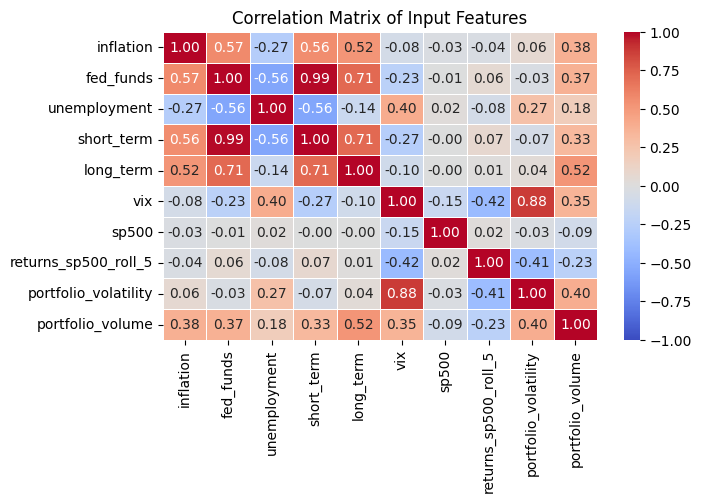

In [29]:
corr_matrix = input_features.corr()

plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix of Input Features")
plt.show()

In [30]:
print(f"Nan: {input_features.isna().sum().sum()}")

Nan: 0


In [31]:
input_train = input_features.loc[start_date:backtest_date]
input_test = input_features.loc[backtest_date:backtest_end]

# Scale input_features indicators
input_scaler = StandardScaler()
input_train_scaled = input_scaler.fit_transform(input_train)
input_test_scaled = input_scaler.transform(input_test)

## Define custom layers: Sampling, Reconstruction Loss, KL Divergence

In [32]:
@keras.saving.register_keras_serializable()
class SamplingLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var + 1e-8) * epsilon

"""
@keras.saving.register_keras_serializable()
class ReconstructionLossLayer(layers.Layer):
    def call(self, inputs):
        x, x_pred = inputs
        loss = K.mean(mse(x, x_pred))
        self.add_loss(loss)
        return x_pred
"""

@keras.saving.register_keras_serializable()
class ReconstructionLossLayer(layers.Layer):
    def __init__(self, weight_tail=1.0, **kwargs):
        super(ReconstructionLossLayer, self).__init__(**kwargs)
        self.weight_tail = weight_tail

    def call(self, inputs):
        x, x_pred = inputs
        # Standard MSE loss
        mse_loss = K.mean(mse(x, x_pred))
        # Compute the 5th percentile (tail) for x and x_pred along the batch axis
        # Note: tfp.stats.percentile operates on tensors along a specified dimension
        p_true = tfp.stats.percentile(x, 5.0, interpolation='linear', axis=0)
        p_pred = tfp.stats.percentile(x_pred, 5.0, interpolation='linear', axis=0)
        # To obtain a single value, take the mean across all assets
        tail_loss = tf.reduce_mean(tf.abs(p_true - p_pred))
        # Sum the loss, giving more or less weight to the tail term as needed
        loss = mse_loss + self.weight_tail * tail_loss
        self.add_loss(loss)
        return x_pred


@keras.saving.register_keras_serializable()
class KLDivergenceLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1
        )
        self.add_loss(tf.reduce_mean(kl_loss))
        return z_mean

## Conditional VAE: Unconditioned Encoder, Conditioned Decoder with Dropout

In [33]:
def build_conditional_vae(returns_dim, macro_dim, intermediate_dim=256, latent_dim=2):
    # Encoder
    x_input = layers.Input(shape=(returns_dim,), name="returns_input")
    h = layers.Dense(intermediate_dim, activation="relu")(x_input)
    h = layers.Dropout(0.1)(h)
    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)
    z_mean = KLDivergenceLayer()([z_mean, z_log_var])
    z = SamplingLayer(name="z")([z_mean, z_log_var])
    encoder = Model(x_input, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    cond_input = layers.Input(shape=(macro_dim,), name="macro_input")
    decoder_input = layers.Concatenate(name="concat_decoder")([z, cond_input])
    d = layers.Dense(intermediate_dim, activation="relu")(decoder_input)
    d = layers.Dropout(0.1)(d)
    d = layers.Dense(intermediate_dim // 2, activation="relu")(d)
    outputs = layers.Dense(returns_dim, activation="linear")(d)
    decoder = Model([z, cond_input], outputs, name="decoder")

    # Conditional VAE Model
    vae_output = decoder([encoder(x_input)[2], cond_input])
    x_pred = ReconstructionLossLayer()([x_input, vae_output])
    cvae = Model([x_input, cond_input], x_pred, name="cvae")

    # Compile the model
    cvae.compile(optimizer="adam")

    return encoder, decoder, cvae

## Conditional Generator and Critic (WGAN-GP) with Increased Depth and Dropout

In [34]:
def build_conditional_generator(noise_dim, input_dim, latent_dim):
    noise_input = layers.Input(shape=(noise_dim,), name="noise_input")
    input_features = layers.Input(shape=(input_dim,), name="input_features_gen")
    x = layers.Concatenate(name="concat_gen")([noise_input, input_features])
    x = layers.Dense(256, activation="relu")(x)
#    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation="relu")(x)
#    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    output_latent = layers.Dense(latent_dim, name="latent_generated")(x)
    model = Model(
        [noise_input, input_features], output_latent, name="conditional_generator"
    )
    return model


def build_conditional_critic(latent_dim, input_dim):
    latent_input = layers.Input(shape=(latent_dim,), name="latent_input")
    input_features = layers.Input(shape=(input_dim,), name="input_features_critic")
    x = layers.Concatenate(name="concat_critic")([latent_input, input_features])
    x = layers.Dense(256, activation="relu")(x)
#    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation="relu")(x)
#    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    output_score = layers.Dense(1, name="critic_score")(x)
    model = Model([latent_input, input_features], output_score, name="conditional_critic")
    return model


def gradient_penalty_cond(critic, real_latent, fake_latent, input, batch_size):
    alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
    interpolated_latent = alpha * real_latent + (1 - alpha) * fake_latent
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated_latent)
        interpolated_output = critic([interpolated_latent, input])
    grads = gp_tape.gradient(interpolated_output, [interpolated_latent])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-12)
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp


def train_conditional_wgan_gp(
    generator,
    critic,
    real_latent,
    real_input,
    noise_dim,
    batch_size=32,
    epochs=EPOCHS_WGAN,
    critic_iterations=5,
    lambda_gp=10.0,
):
    # Use lower learning rate and clipnorm for stability
    gen_optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-5, beta_1=0.5, beta_2=0.9, clipnorm=1.0
    )
    critic_optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-5, beta_1=0.5, beta_2=0.9, clipnorm=1.0
    )

    dataset = tf.data.Dataset.from_tensor_slices(
        (real_latent.astype("float32"), real_input.astype("float32"))
    )
    dataset = dataset.shuffle(1024).batch(batch_size)

    for epoch in range(1, epochs+1):
        for latent_batch, input_batch in dataset:
            current_batch_size = tf.shape(input_batch)[0]
            for _ in range(critic_iterations):
                noise = tf.random.normal([current_batch_size, noise_dim])
                with tf.GradientTape() as tape:
                    fake_latent = generator([noise, input_batch])
                    critic_real = critic([latent_batch, input_batch])
                    critic_fake = critic([fake_latent, input_batch])
                    gp = gradient_penalty_cond(
                        critic,
                        latent_batch,
                        fake_latent,
                        input_batch,
                        current_batch_size,
                    )
                    critic_loss = (
                        tf.reduce_mean(critic_fake)
                        - tf.reduce_mean(critic_real)
                        + lambda_gp * gp
                    )
                grads = tape.gradient(critic_loss, critic.trainable_variables)
                critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

            noise = tf.random.normal([current_batch_size, noise_dim])
            with tf.GradientTape() as tape:
                fake_latent = generator([noise, input_batch])
                gen_loss = -tf.reduce_mean(critic([fake_latent, input_batch]))
            grads = tape.gradient(gen_loss, generator.trainable_variables)
            gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}: Critic Loss = {critic_loss.numpy():.4f}, Gen Loss = {gen_loss.numpy():.4f}")

    return generator

## Metrics and Validation Functions

In [35]:
def compute_portfolio_returns(returns_array, weights):
    return returns_array.dot(weights)


def calculate_var_es(portfolio_returns, alpha=5):
    var_threshold = np.percentile(portfolio_returns, alpha)
    es = portfolio_returns[portfolio_returns <= var_threshold].mean()
    return var_threshold, es


def select_extreme_scenarios(synthetic_returns, portfolio_weights, alpha=5):
    portfolio_returns = compute_portfolio_returns(synthetic_returns, portfolio_weights)
    var_threshold, es = calculate_var_es(portfolio_returns, alpha)
    extreme_indices = np.where(portfolio_returns <= var_threshold)[0]
    extreme_scenarios = synthetic_returns[extreme_indices]
    return extreme_scenarios, var_threshold, es, portfolio_returns


def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))

## Clustering Function for Latent Space Scenarios

In [36]:
def cluster_extreme_latent(z_codes, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED_RANDOM)
    clusters = kmeans.fit_predict(z_codes)
    global_center = np.mean(z_codes, axis=0)
    distances = np.linalg.norm(kmeans.cluster_centers_ - global_center, axis=1)
    extreme_cluster = np.argmax(distances)
    extreme_indices = np.where(clusters == extreme_cluster)[0]
    return extreme_indices, clusters, kmeans.cluster_centers_

## Training and Stress Testing

In [37]:
n_samples = min(returns_train_scaled.shape[0], input_train_scaled.shape[0])
returns_scaled = returns_train_scaled[:n_samples]
input_train_scaled = input_train_scaled[:n_samples]

### VAE

In [38]:
return_dim = returns_scaled.shape[1]
input_dim = input_train_scaled.shape[1]
latent_dim = LATENT_DIM
noise_dim = NOISE_DIM

print(f"Returns dim: {return_dim}")
print(f"Input dim: {input_dim}")
print(f"Latent dim: {latent_dim}")
print(f"Noise dim: {noise_dim}")

Returns dim: 30
Input dim: 10
Latent dim: 5
Noise dim: 2


In [39]:
print("Training Conditional VAE...")
encoder, decoder, cvae = build_conditional_vae(
    return_dim, input_dim, intermediate_dim=256, latent_dim=latent_dim
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

cvae.fit(
    [returns_scaled, input_train_scaled],
    epochs=EPOCHS_CVAE,
    batch_size=32,
    validation_split=0.1,
#    callbacks=[early_stop],
    verbose=0
)
z_mean_train, _, _ = encoder.predict(returns_scaled)

Training Conditional VAE...


I0000 00:00:1741501570.965716  177191 gpu_device.cc:2018] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'


2025-03-09 01:26:12.499366: I external/local_xla/xla/service/service.cc:152] XLA service 0x7764d000bef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-09 01:26:12.499377: I external/local_xla/xla/service/service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-03-09 01:26:12.527121: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741501572.673459  177416 cuda_dnn.cc:529] Loaded cuDNN version 90800


2025-03-09 01:26:14.347160: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1808', 32 bytes spill stores, 32 bytes spill loads



2025-03-09 01:26:14.747277: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1808', 40 bytes spill stores, 40 bytes spill loads



I0000 00:00:1741501576.647210  177416 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2025-03-09 01:26:18.369726: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1123', 4 bytes spill stores, 4 bytes spill loads



2025-03-09 01:26:21.090879: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads

2025-03-09 01:26:21.109191: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154', 4 bytes spill stores, 4 bytes spill loads



2025-03-09 01:26:22.288503: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads

2025-03-09 01:26:22.469470: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154', 8 bytes spill stores, 8 bytes spill loads



2025-03-09 01:26:22.849723: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154', 4 bytes spill stores, 4 bytes spill loads




  1/127 ━━━━━━━━━━━━━━━━━━━━ 47s 378ms/step

2025-03-09 01:27:48.777578: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads




127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step   


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


### WGAN-GP

In [ ]:
def train_conditional_wgan_gp(
    generator,
    critic,
    real_latent,
    real_input,
    noise_dim,
    batch_size=32,
    epochs=EPOCHS_WGAN,
    critic_iterations=5,
    lambda_gp=10.0,
    validation_split=0.1,      
    sp500_index=None,        
    worst_case_quantile=0.1, 
    worst_case_weight=2.0,  
    patience=20  
):
    """
    Train a conditional WGAN-GP with early stopping and weighted validation
    """
    gen_optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-5, beta_1=0.5, beta_2=0.9, clipnorm=1.0
    )
    critic_optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-5, beta_1=0.5, beta_2=0.9, clipnorm=1.0
    )

    # Check that sp500_index is provided
    if sp500_index is None:
        raise ValueError("sp500_index must be provided to weight worst-case validation samples.")
    
    # Split the data into training and validation sets (using the last validation_split portion)
    num_samples = real_input.shape[0]
    n_val = int(validation_split * num_samples)
    train_latent = real_latent[:-n_val]
    train_input = real_input[:-n_val]
    val_latent = real_latent[-n_val:]
    val_input = real_input[-n_val:]
    
    # Create the training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (train_latent.astype("float32"), train_input.astype("float32"))
    )
    train_dataset = train_dataset.shuffle(1024).batch(batch_size)
    
    # Initialize lists for tracking losses and early stopping
    gen_losses = []
    critic_losses = []
    val_losses = []
    best_val_loss = np.inf
    epochs_no_improve = 0

    # Training loop
    for epoch in range(1, epochs + 1):
        epoch_gen_losses = []
        epoch_critic_losses = []
    
        for latent_batch, input_batch in train_dataset:
            current_batch_size = tf.shape(input_batch)[0]
            # Update critic for critic_iterations steps
            for _ in range(critic_iterations):
                noise = tf.random.normal([current_batch_size, noise_dim])
                with tf.GradientTape() as tape:
                    fake_latent = generator([noise, input_batch])
                    critic_real = critic([latent_batch, input_batch])
                    critic_fake = critic([fake_latent, input_batch])
                    gp = gradient_penalty_cond(
                        critic, latent_batch, fake_latent, input_batch, current_batch_size
                    )
                    critic_loss = (
                        tf.reduce_mean(critic_fake)
                        - tf.reduce_mean(critic_real)
                        + lambda_gp * gp
                    )
                grads = tape.gradient(critic_loss, critic.trainable_variables)
                critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))
                epoch_critic_losses.append(critic_loss.numpy())
    
            # Update generator
            noise = tf.random.normal([current_batch_size, noise_dim])
            with tf.GradientTape() as tape:
                fake_latent = generator([noise, input_batch])
                gen_loss = -tf.reduce_mean(critic([fake_latent, input_batch]))
            grads = tape.gradient(gen_loss, generator.trainable_variables)
            gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
            epoch_gen_losses.append(gen_loss.numpy())
    
        avg_gen_loss = np.mean(epoch_gen_losses)
        avg_critic_loss = np.mean(epoch_critic_losses)
        total_train_loss = avg_gen_loss + avg_critic_loss
    
        gen_losses.append(avg_gen_loss)
        critic_losses.append(avg_critic_loss)
    
        # --- Validation Evaluation ---
        # Convert validation input to tensor
        val_input_tensor = tf.convert_to_tensor(val_input, dtype=tf.float32)
        # Generate noise for validation samples
        val_noise = tf.random.normal([n_val, noise_dim])
        # Compute generator loss on the entire validation set
        val_fake_latent = generator([val_noise, val_input_tensor])
        val_gen_loss_all = -tf.reduce_mean(critic([val_fake_latent, val_input_tensor])).numpy()
    
        # Identify worst-case samples in the validation set using the SP500 indicator
        sp500_vals = val_input[:, sp500_index]
        threshold = np.percentile(sp500_vals, worst_case_quantile * 100)
        worst_mask = sp500_vals < threshold
        if np.sum(worst_mask) > 0:
            worst_input = val_input[worst_mask]
            worst_input_tensor = tf.convert_to_tensor(worst_input, dtype=tf.float32)
            worst_noise = tf.random.normal([worst_input.shape[0], noise_dim])
            worst_fake_latent = generator([worst_noise, worst_input_tensor])
            val_gen_loss_worst = -tf.reduce_mean(critic([worst_fake_latent, worst_input_tensor])).numpy()
        else:
            val_gen_loss_worst = 0.0
    
        # Combined validation loss: weighted average of overall and worst-case losses
        combined_val_loss = (val_gen_loss_all + worst_case_weight * val_gen_loss_worst) / (1.0 + worst_case_weight)
        val_losses.append(combined_val_loss)
        
        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}: Critic Loss = {avg_critic_loss:.4f}, Gen Loss = {avg_gen_loss:.4f}, Val Loss = {combined_val_loss:.4f}")
        logging.info(f"Epoch {epoch}")
    
        # Early stopping check on the validation loss
        if combined_val_loss < best_val_loss:
            best_val_loss = combined_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break
    
    return generator, gen_losses, critic_losses, val_losses

In [41]:
input_test_indices = {col: idx for idx, col in enumerate(input_test.columns)}

In [42]:
print("Training Conditional WGAN-GP...")
generator = build_conditional_generator(noise_dim, input_dim, latent_dim)
critic = build_conditional_critic(latent_dim, input_dim)
generator, gen_losses, critic_losses, val_losses = train_conditional_wgan_gp(
    generator,
    critic,
    z_mean_train,
    input_train_scaled,
    noise_dim,
    batch_size=32,
    epochs=EPOCHS_WGAN,
    critic_iterations=5,
    lambda_gp=20.0,
    sp500_index=input_test_indices["returns_sp500_roll_5"],
    patience=400,
    validation_split=0.3,
    worst_case_quantile=0.2,
    worst_case_weight=3.0, 
)

Training Conditional WGAN-GP...


2025-03-09 01:28:10.026680: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1: Critic Loss = 14.1639, Gen Loss = -0.0434, Val Loss = -0.0749


2025-03-09 01:28:29.642153: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-09 01:29:09.721303: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-09 01:30:30.461257: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10: Critic Loss = 5.8683, Gen Loss = -1.9583, Val Loss = -1.7248


2025-03-09 01:33:10.967668: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20: Critic Loss = 10.1373, Gen Loss = -5.1879, Val Loss = -3.5270


Epoch 30: Critic Loss = -5.3472, Gen Loss = 3.3953, Val Loss = 2.0361


2025-03-09 01:38:32.887361: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40: Critic Loss = 0.3752, Gen Loss = -1.0965, Val Loss = 0.2205


Epoch 50: Critic Loss = 0.1478, Gen Loss = -1.2725, Val Loss = 0.6152


Epoch 60: Critic Loss = 0.2751, Gen Loss = 0.6690, Val Loss = 1.2629


2025-03-09 01:49:25.282235: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 70: Critic Loss = -0.0040, Gen Loss = -0.3137, Val Loss = -0.6640


Epoch 80: Critic Loss = -0.2439, Gen Loss = 2.7883, Val Loss = 1.7483


Epoch 90: Critic Loss = 0.4492, Gen Loss = -4.3851, Val Loss = -3.1515


Epoch 100: Critic Loss = -0.0864, Gen Loss = -0.2961, Val Loss = -0.8141


Epoch 110: Critic Loss = 0.5647, Gen Loss = 2.7331, Val Loss = 2.2339


Epoch 120: Critic Loss = 1.0299, Gen Loss = 2.1681, Val Loss = 2.1880


2025-03-09 03:11:10.369563: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 130: Critic Loss = 1.4322, Gen Loss = -0.0024, Val Loss = -1.0578


Epoch 140: Critic Loss = 0.7215, Gen Loss = -6.4060, Val Loss = -3.9384


Epoch 150: Critic Loss = 0.5450, Gen Loss = -1.7545, Val Loss = -1.3334


Epoch 160: Critic Loss = 0.4883, Gen Loss = 1.8624, Val Loss = 1.6811


Epoch 170: Critic Loss = 0.2874, Gen Loss = -4.2924, Val Loss = -2.1305


Epoch 180: Critic Loss = 0.0573, Gen Loss = -0.7547, Val Loss = -0.4000


Epoch 190: Critic Loss = 0.0226, Gen Loss = -0.5155, Val Loss = -0.2819


Epoch 200: Critic Loss = 0.0146, Gen Loss = -0.6567, Val Loss = -0.3372


Epoch 210: Critic Loss = 0.0103, Gen Loss = -0.5656, Val Loss = -0.3646


Epoch 220: Critic Loss = 0.0087, Gen Loss = -0.5032, Val Loss = -0.2644


Epoch 230: Critic Loss = 0.0057, Gen Loss = -0.3694, Val Loss = -0.2455


Epoch 240: Critic Loss = 0.0050, Gen Loss = -0.4193, Val Loss = -0.2604


Epoch 250: Critic Loss = 0.0044, Gen Loss = -0.3930, Val Loss = -0.2414


2025-03-09 03:54:28.845571: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 260: Critic Loss = 0.0031, Gen Loss = -0.4242, Val Loss = -0.2486


Epoch 270: Critic Loss = 0.0027, Gen Loss = -0.3447, Val Loss = -0.2183


Epoch 280: Critic Loss = 0.0024, Gen Loss = -0.3799, Val Loss = -0.2369


Epoch 290: Critic Loss = 0.0027, Gen Loss = -0.3819, Val Loss = -0.2707


Epoch 300: Critic Loss = 0.0021, Gen Loss = -0.3617, Val Loss = -0.2430


Epoch 310: Critic Loss = 0.0017, Gen Loss = -0.3287, Val Loss = -0.2619


Epoch 320: Critic Loss = 0.0013, Gen Loss = -0.3328, Val Loss = -0.2232


Epoch 330: Critic Loss = 0.0007, Gen Loss = -0.3130, Val Loss = -0.2468


Epoch 340: Critic Loss = 0.0006, Gen Loss = -0.3079, Val Loss = -0.2028


Epoch 350: Critic Loss = 0.0008, Gen Loss = -0.2988, Val Loss = -0.2510


Epoch 360: Critic Loss = -0.0002, Gen Loss = -0.2946, Val Loss = -0.2547


Epoch 370: Critic Loss = 0.0002, Gen Loss = -0.2691, Val Loss = -0.1855


Epoch 380: Critic Loss = -0.0003, Gen Loss = -0.2718, Val Loss = -0.2242


Epoch 390: Critic Loss = -0.0002, Gen Loss = -0.2751, Val Loss = -0.2434


Epoch 400: Critic Loss = -0.0003, Gen Loss = -0.3407, Val Loss = -0.2584


Epoch 410: Critic Loss = -0.0004, Gen Loss = -0.3302, Val Loss = -0.2625


Early stopping triggered at epoch 418


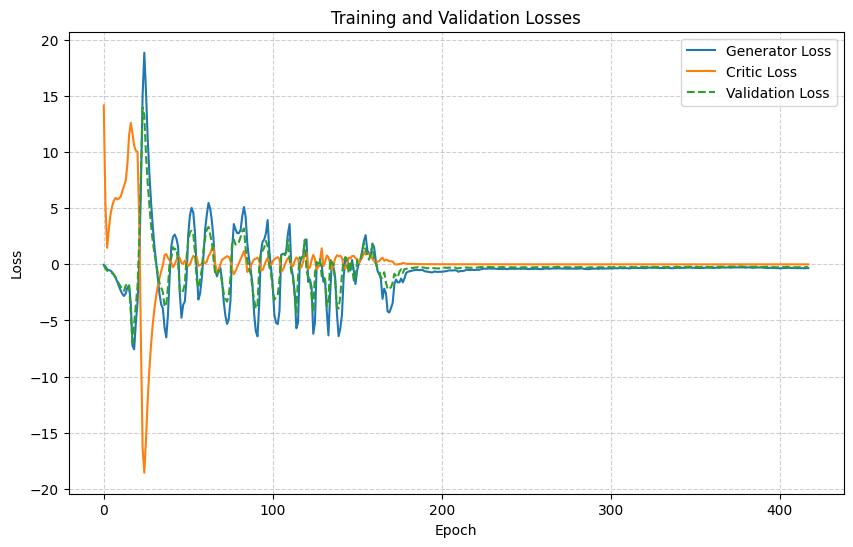

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(critic_losses, label='Critic Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### Save Models

In [44]:
encoder.save("models/encoder_model.keras")
decoder.save("models/decoder_model.keras")
cvae.save("models/cvae_model.keras")
generator.save("models/generator_model.keras")
critic.save("models/critic_model.keras")
logging.info("saved models")

In [45]:
# Define the missing custom layer
custom_objects = {
    "KLDivergenceLayer": KLDivergenceLayer,
    "ReconstructionLossLayer": ReconstructionLossLayer,
    "SamplingLayer": SamplingLayer,
}

# Load the models with the custom layer
#encoder = load_model("models/encoder_model.keras", custom_objects=custom_objects)
#decoder = load_model("models/decoder_model.keras", custom_objects=custom_objects)
#cvae = load_model("models/cvae_model.keras", custom_objects=custom_objects)
#generator = load_model("models/generator_model.keras", custom_objects=custom_objects)
#critic = load_model("models/critic_model.keras", custom_objects=custom_objects)

### Generate New Synthetic Scenarios

In [46]:
def create_stressed_input_condition(input_condition, indices, stress_values, scaler, i=0):
    """
    Copies the condition vector and sets specific macroeconomic indicators to stressed values.
    """
    stressed_condition = input_condition.copy()
    for key, idx in indices.items():
        if key in stress_values:
            stressed_condition.iloc[i, idx] = stress_values[key]
    return scaler.transform(stressed_condition), stressed_condition

stress_values = {
#    "fed_funds": 0.01,
#    "long_term": 2.0,
#    "vix": 99.0,
#    "eurusd": 2.0,
#    "inflation": 4.0,
#    "unemployment": 20.0,
}

### test

In [ ]:
def generate_scenarios_for_one_day(input_condition_vector, num_scenarios, noise_dim, generator, decoder, returns_scaler):
    """
    Generate synthetic scenarios for one day given the input condition.
    """
    # Convert input condition vector into a tensor and repeat it
    input_condition = tf.convert_to_tensor(np.atleast_2d(input_condition_vector), dtype=tf.float32)
    input_condition = tf.repeat(input_condition, repeats=num_scenarios, axis=0)
    
    # Generate noise and latent code with generator
    noise = tf.random.normal([num_scenarios, noise_dim])
    generated_latent = generator([noise, input_condition]).numpy()
    
    # Decode the latent code (conditional on the input condition)
    synthetic_returns_scaled = decoder.predict([generated_latent, input_condition])
    
    # Check and fix shape: expect (num_scenarios, return_dim)
    if synthetic_returns_scaled.shape[0] != num_scenarios:
        synthetic_returns_scaled = synthetic_returns_scaled.T
    
    synthetic_returns = returns_scaler.inverse_transform(synthetic_returns_scaled)
    if synthetic_returns.shape[0] != num_scenarios:
        synthetic_returns = synthetic_returns.T
        
    return synthetic_returns, generated_latent, input_condition


def rolling_backtest(returns_test, input_test_scaled, input_test, noise_dim, generator, decoder, returns_scaler, portfolio_weights, num_scenarios, input_test_indices, stress_values=None):
    # returns_test and input_test_scaled are assumed to be aligned (input shifted by one)
    backtest_dates = returns_test.index
    backtest_results = []
    
    for i in range(len(backtest_dates)):
        forecast_date = backtest_dates[i]
        
        # During scenario generation:
        if stress_values != None:
            input_test_scaled, input_test = create_stressed_input_condition(input_test, input_test_indices, stress_values, input_scaler, i)
        condition = input_test_scaled[i]
        # Use the stressed condition vector to generate scenarios
        synthetic_returns, _, _ = generate_scenarios_for_one_day(condition, num_scenarios, noise_dim, generator, decoder, returns_scaler)

        #synthetic_returns, _, _ = generate_scenarios_for_one_day(input_condition_vector, num_scenarios, noise_dim, generator, decoder, returns_scaler)
        
        synthetic_returns_df = pd.DataFrame(synthetic_returns, columns=returns_test.columns)
        synthetic_portfolio_returns = synthetic_returns_df.dot(portfolio_weights)
        var_synth, es_synth = calculate_var_es(synthetic_portfolio_returns, alpha=5)
        
        hist_portfolio_return = returns_test.loc[forecast_date].dot(portfolio_weights)
        
        backtest_results.append({
            "forecast_date": forecast_date,
            "hist_portfolio_return": hist_portfolio_return,
            "synthetic_VaR": var_synth,
            "synthetic_ES": es_synth
        })
    return pd.DataFrame(backtest_results), synthetic_returns_df


vol_indices = np.where([col.startswith('vol_') for col in input_train.columns])[0]

def calculate_var_es(portfolio_returns, alpha=5):
    """
    Compute Value at Risk (VaR) and Expected Shortfall (ES) for a 1D array of portfolio returns.
    """
    var_threshold = np.percentile(portfolio_returns, alpha)
    es = portfolio_returns[portfolio_returns <= var_threshold].mean()
    return var_threshold, es

In [ ]:
input_test_indices = {col: idx for idx, col in enumerate(input_test.columns)}
backtest_df, ret = rolling_backtest(returns_test, input_test_scaled, input_test, NOISE_DIM, generator, decoder, returns_scaler, portfolio_weights, NUM_SCENARIOS, input_test_indices, stress_values)
print("Rolling backtest results:")
backtest_df.head()


  1/313 ━━━━━━━━━━━━━━━━━━━━ 6:08 1s/step


110/313 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step


228/313 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


115/313 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step


231/313 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 79/313 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step


196/313 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step


310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


112/313 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


224/313 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step


116/313 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step


227/313 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


110/313 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step


225/313 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 86/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


202/313 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


 93/313 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step


210/313 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


100/313 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


221/313 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


 83/313 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step


195/313 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


 96/313 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


205/313 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


 81/313 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step


203/313 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


 96/313 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step


209/313 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


102/313 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step


219/313 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


 92/313 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step


209/313 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


 98/313 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step


207/313 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 97/313 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step


204/313 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


288/313 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 84/313 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step


195/313 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step


302/313 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


 98/313 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


206/313 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 90/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


196/313 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step


304/313 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


108/313 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step


215/313 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 81/313 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step


194/313 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step


310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 97/313 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step


205/313 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


 97/313 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step


207/313 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


 87/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


202/313 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 80/313 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step


193/313 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step


304/313 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 92/313 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step


205/313 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 96/313 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step


207/313 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


 80/313 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step


192/313 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step


307/313 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


 76/313 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step


183/313 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step


291/313 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 94/313 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step


206/313 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 99/313 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step


212/313 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


 98/313 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step


210/313 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 99/313 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step


212/313 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


 87/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


198/313 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


 69/313 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


178/313 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step


288/313 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 92/313 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step


214/313 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 85/313 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step


200/313 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 81/313 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step


193/313 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step


303/313 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 94/313 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step


201/313 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step


309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


 81/313 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step


182/313 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step


289/313 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 73/313 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step


180/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


288/313 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 82/313 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step


193/313 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step


302/313 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 97/313 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step


203/313 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


 77/313 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step


183/313 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step


289/313 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 90/313 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


202/313 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step


309/313 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


 92/313 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step


210/313 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


 72/313 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step


179/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


284/313 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


 86/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


194/313 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


307/313 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 88/313 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


201/313 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


 90/313 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


205/313 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


Rolling backtest results:


forecast_date  hist_portfolio_return  synthetic_VaR  synthetic_ES
0    2020-02-20              -0.006224      -0.027610     -0.027615
1    2020-02-21              -0.016266      -0.036676     -0.036686
2    2020-02-24              -0.042082      -0.055537     -0.055539
3    2020-02-25              -0.032877      -0.059736     -0.059740
4    2020-02-26               0.001837      -0.043884     -0.043896

### test

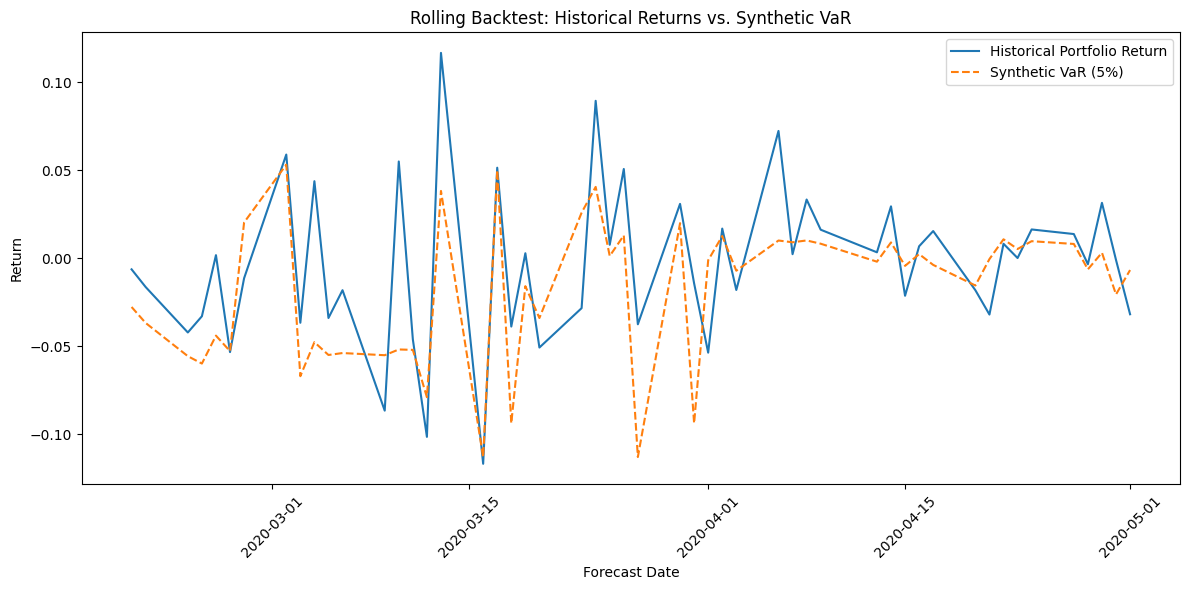

In [49]:
# Plot the historical portfolio returns and synthetic VaR over the backtest period
plt.figure(figsize=(12, 6))
plt.plot(
    backtest_df["forecast_date"],
    backtest_df["hist_portfolio_return"],
    label="Historical Portfolio Return",
    linestyle="-",
)
plt.plot(
    backtest_df["forecast_date"],
    backtest_df["synthetic_VaR"],
    label="Synthetic VaR (5%)",
    linestyle="--",
)
plt.xlabel("Forecast Date")
plt.ylabel("Return")
plt.title("Rolling Backtest: Historical Returns vs. Synthetic VaR")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

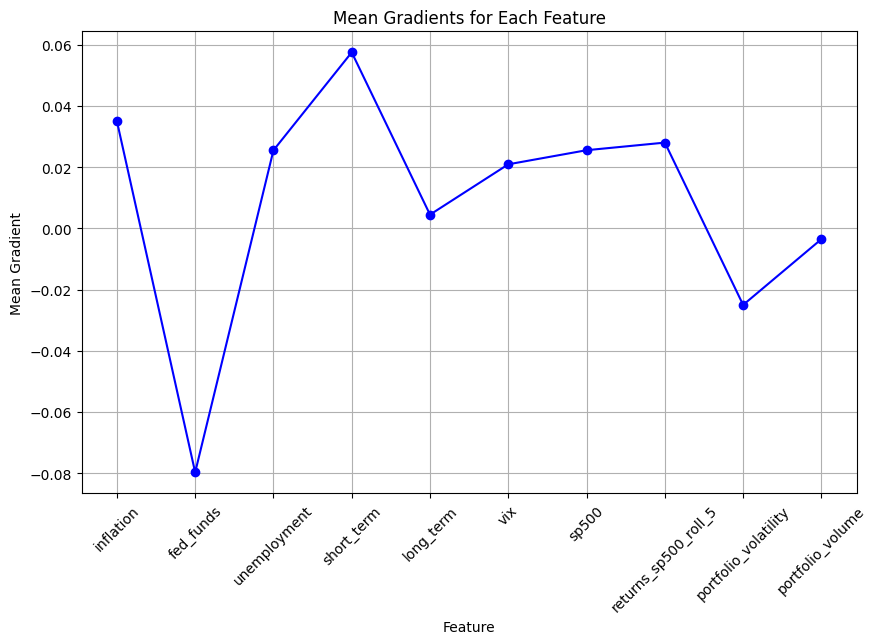

In [50]:
num_scenarios = len(input_test)

gradients_list = []

for i in range(num_scenarios):
    input_condition_tensor = tf.convert_to_tensor(np.atleast_2d(input_test.iloc[i]), dtype=tf.float32)
    noise = tf.random.normal([1, NOISE_DIM])
    
    with tf.GradientTape() as tape:
        tape.watch(input_condition_tensor)
        output = generator([noise, input_condition_tensor])
    
    gradients = tape.gradient(output, input_condition_tensor)
    gradients_list.append(gradients.numpy())

mean_gradients = np.mean(gradients_list, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(input_test.columns, mean_gradients[0], marker='o', linestyle='-', color='b')
plt.title('Mean Gradients for Each Feature')
plt.xlabel('Feature')
plt.ylabel('Mean Gradient')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [51]:
def rolling_backtest_tickers(returns_test, input_test_scaled, input_test, noise_dim, generator, decoder, returns_scaler, num_scenarios, input_test_indices, stress_values=None):
    # returns_test and input_test_scaled are assumed to be aligned (input shifted by one)
    backtest_dates = returns_test.index
    backtest_results = []

    for i in range(len(backtest_dates)):
        forecast_date = backtest_dates[i]

        # Apply stress conditions if needed
        if stress_values is not None:
            input_test_scaled, input_test = create_stressed_input_condition(input_test, input_test_indices, stress_values, input_scaler, i)
        condition = input_test_scaled[i]

        # Generate synthetic scenarios
        synthetic_returns, _, _ = generate_scenarios_for_one_day(condition, num_scenarios, noise_dim, generator, decoder, returns_scaler)
        
        # Convert to DataFrame
        synthetic_returns_df = pd.DataFrame(synthetic_returns, columns=returns_test.columns)

        # Compute historical returns for each stock
        hist_stock_returns = returns_test.loc[forecast_date]

        # Compute VaR and ES for each stock
        var_synth_dict = {}
        es_synth_dict = {}

        for stock in synthetic_returns_df.columns:
            stock_returns = synthetic_returns_df[stock]
            var_synth, es_synth = calculate_var_es(stock_returns, alpha=5)
            var_synth_dict[f"synthetic_VaR_{stock}"] = var_synth
            es_synth_dict[f"synthetic_ES_{stock}"] = es_synth

        # Save results for this date
        backtest_results.append({
            "forecast_date": forecast_date,
            **{f"hist_return_{stock}": hist_stock_returns[stock] for stock in returns_test.columns},
            **var_synth_dict,
            **es_synth_dict
        })

    return pd.DataFrame(backtest_results)


In [ ]:
input_test_indices = {col: idx for idx, col in enumerate(input_test.columns)}
backtest_df = rolling_backtest_tickers(returns_test, input_test_scaled, input_test, NOISE_DIM, generator, decoder, returns_scaler, NUM_SCENARIOS, input_test_indices, stress_values)
print("Rolling backtest results:")
backtest_df.head()


  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


115/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step


232/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


120/313 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


243/313 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


122/313 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step


251/313 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


102/313 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


217/313 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


114/313 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step


236/313 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


117/313 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step


239/313 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


111/313 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step


221/313 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


118/313 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step


235/313 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


109/313 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step


219/313 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


119/313 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


239/313 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


107/313 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step


212/313 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


110/313 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step


216/313 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


112/313 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


223/313 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


118/313 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


232/313 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


115/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step


225/313 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


114/313 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step


224/313 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


117/313 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


228/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


120/313 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step


235/313 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


114/313 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step


231/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


118/313 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step


229/313 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


114/313 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step


228/313 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


119/313 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


235/313 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


115/313 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step


226/313 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


119/313 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


231/313 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


120/313 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


239/313 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


120/313 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


235/313 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


112/313 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


226/313 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


119/313 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


232/313 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


111/313 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step


218/313 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


118/313 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step


238/313 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


120/313 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step


236/313 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


115/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step


228/313 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


112/313 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


224/313 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


123/313 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step


238/313 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


114/313 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step


229/313 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


116/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


235/313 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


116/313 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step


229/313 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


119/313 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


236/313 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


112/313 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step


225/313 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


113/313 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


226/313 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


118/313 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


236/313 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


115/313 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step


231/313 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


118/313 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


226/313 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


110/313 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step


220/313 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


117/313 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step


229/313 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


119/313 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step


236/313 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


109/313 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step


218/313 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


118/313 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


239/313 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


107/313 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


223/313 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


116/313 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step


232/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step



  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


119/313 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


232/313 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step


Rolling backtest results:


forecast_date  hist_return_AAPL  hist_return_AMZN  hist_return_AXP  \
0    2020-02-20         -0.010312         -0.007920        -0.002559   
1    2020-02-21         -0.022896         -0.026892        -0.012377   
2    2020-02-24         -0.048665         -0.042235        -0.051020   
3    2020-02-25         -0.034459         -0.018358        -0.058550   
4    2020-02-26          0.015739          0.003466        -0.020051   

   hist_return_BAC  hist_return_BIIB  hist_return_BK  hist_return_COST  \
0         0.003737         -0.012986       -0.001962          0.003276   
1        -0.014160          0.000208       -0.017388         -0.006594   
2        -0.048601         -0.032386       -0.043332         -0.026214   
3        -0.051728         -0.005753       -0.036359         -0.028297   
4        -0.014584          0.010252       -0.005304          0.002686   

   hist_return_DVA  hist_return_GL  ...  synthetic_ES_PNC  synthetic_ES_SIRI  \
0        -0.009874        0.005322  ...         -0.010342           0.022985   
1        -0.006638       -0.009218  ...         -0.017359           0.022764   
2        -0.014735       -0.032012  ...         -0.031282           0.030377   
3        -0.022086       -0.034235  ...         -0.032100           0.051062   
4        -0.000123       -0.022963  ...         -0.019853           0.034480   

   synthetic_ES_SPY  synthetic_ES_SU  synthetic_ES_TEVA  synthetic_ES_TRV  \
0         -0.018528        -0.055572          -0.027338          0.001011   
1         -0.022687        -0.048030          -0.024868         -0.010246   
2         -0.040030        -0.057609          -0.034600         -0.034432   
3         -0.042776         0.001253          -0.012853         -0.054337   
4         -0.032058        -0.002768          -0.014140         -0.040625   

   synthetic_ES_UPS  synthetic_ES_USB  synthetic_ES_VRSN  synthetic_ES_WFC  
0         -0.021057         -0.010090          -0.038636         -0.018473  
1         -0.021816         -0.022679          -0.045441         -0.042139  
2         -0.032406         -0.045202          -0.064239         -0.078721  
3         -0.026776         -0.048280          -0.054445         -0.098847  
4         -0.023410         -0.038665          -0.042117         -0.069304  

[5 rows x 91 columns]

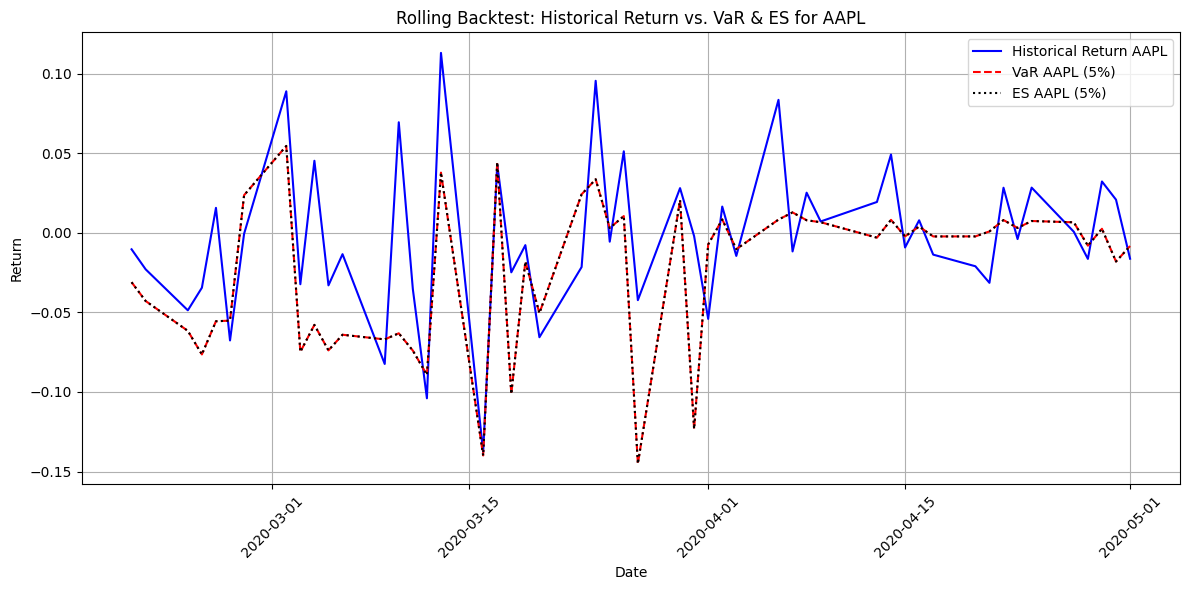

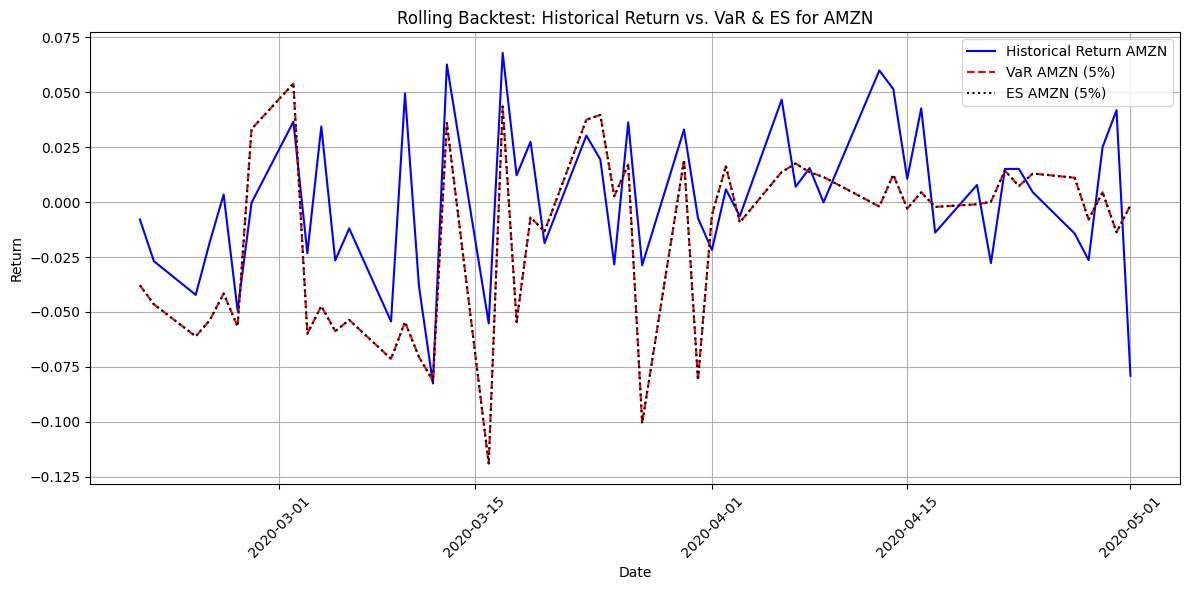

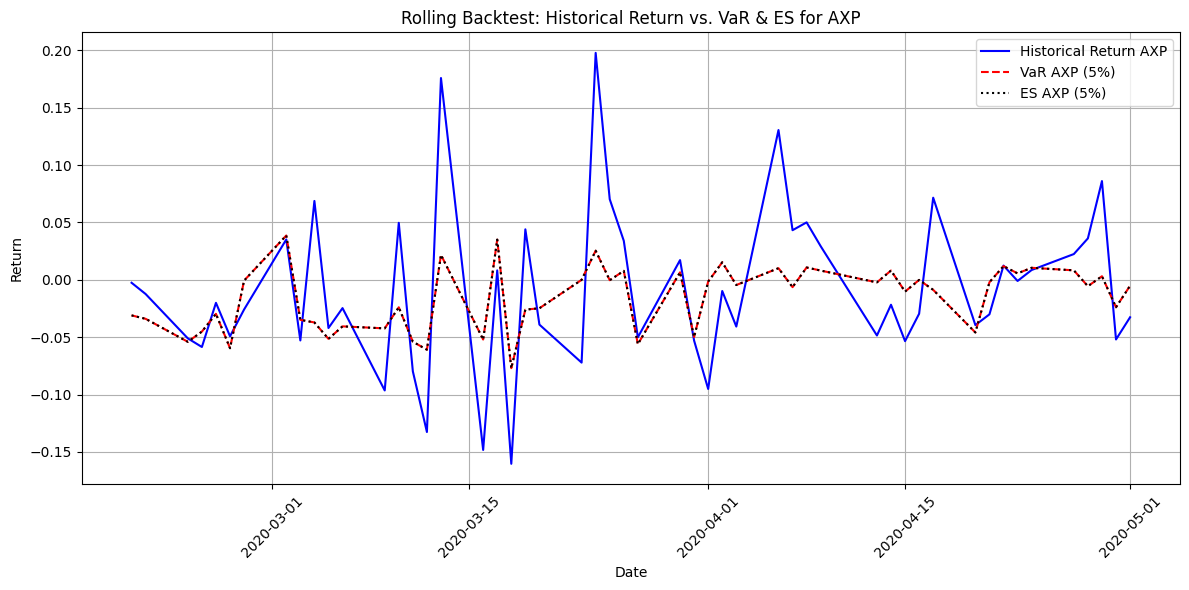

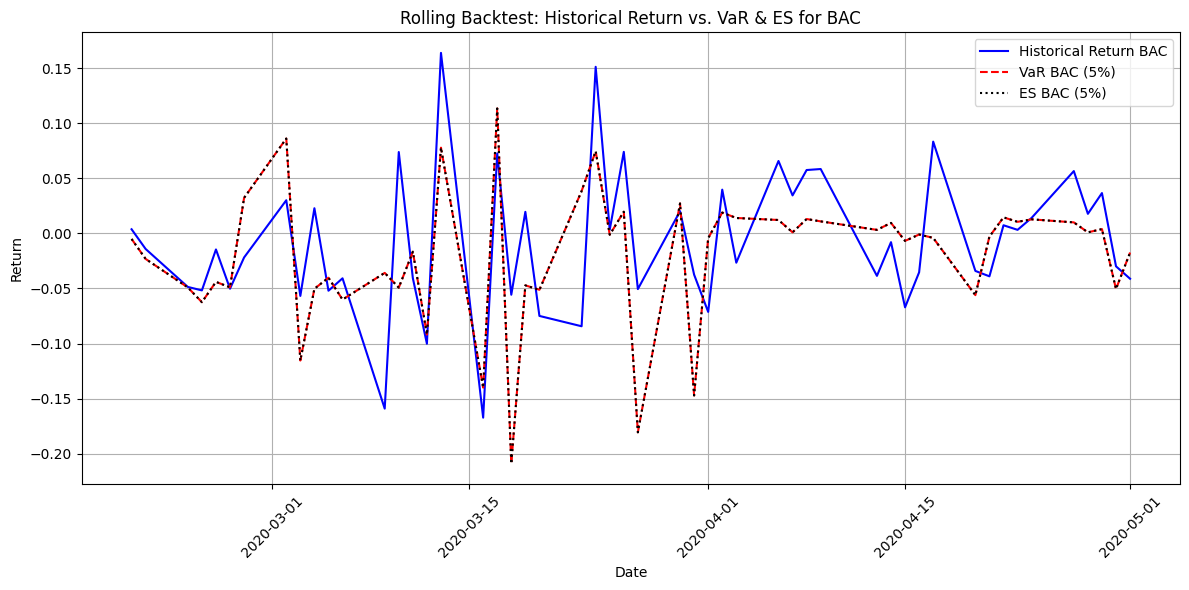

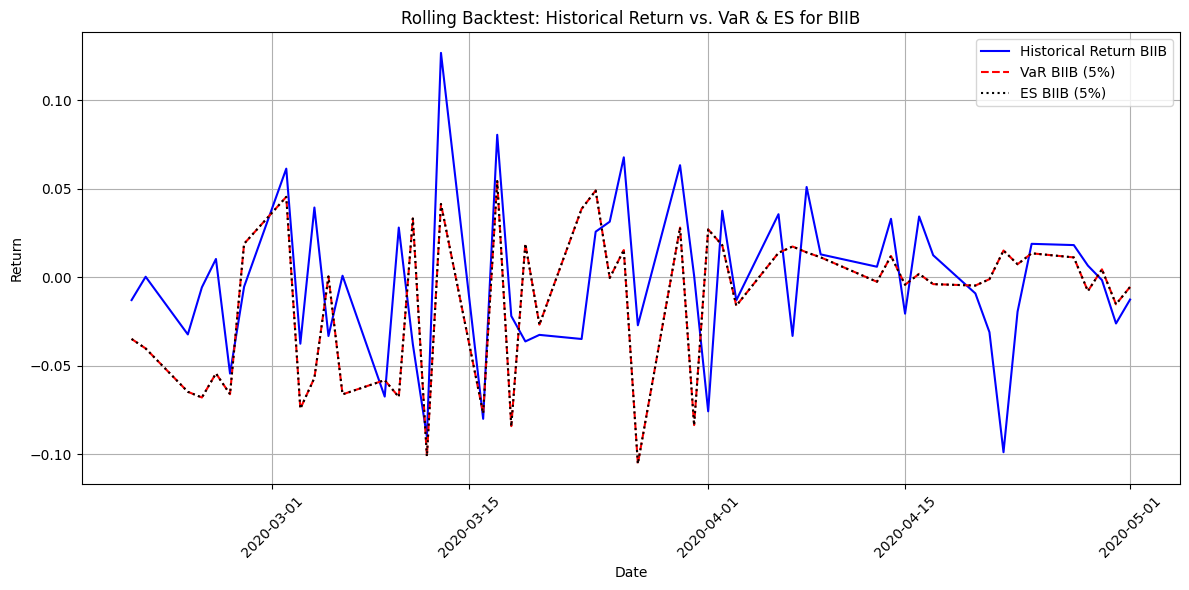

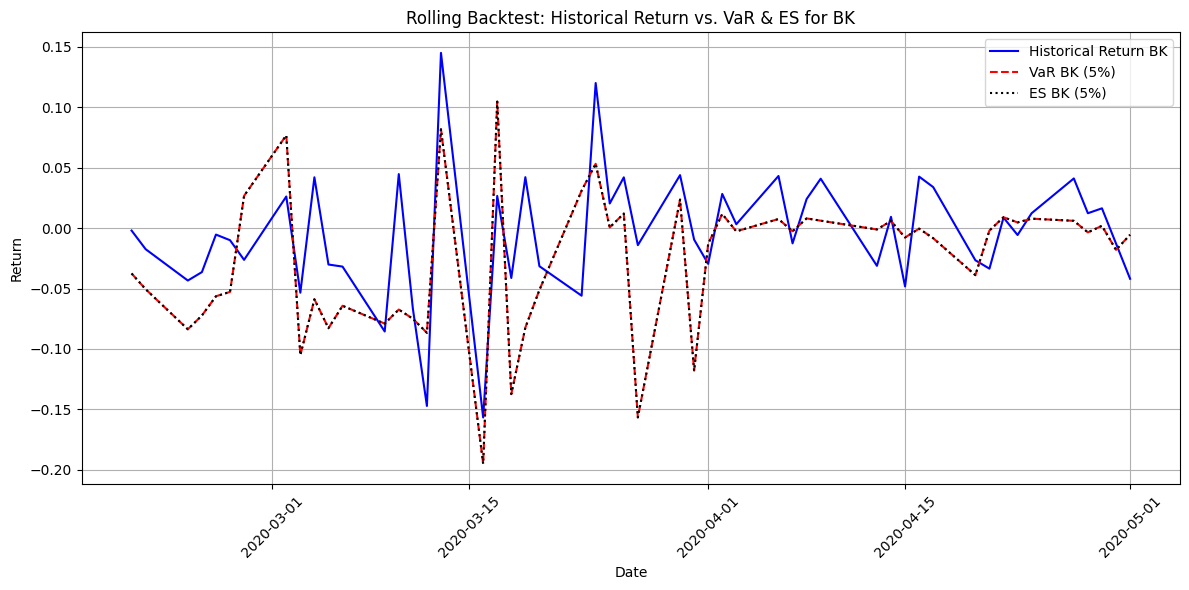

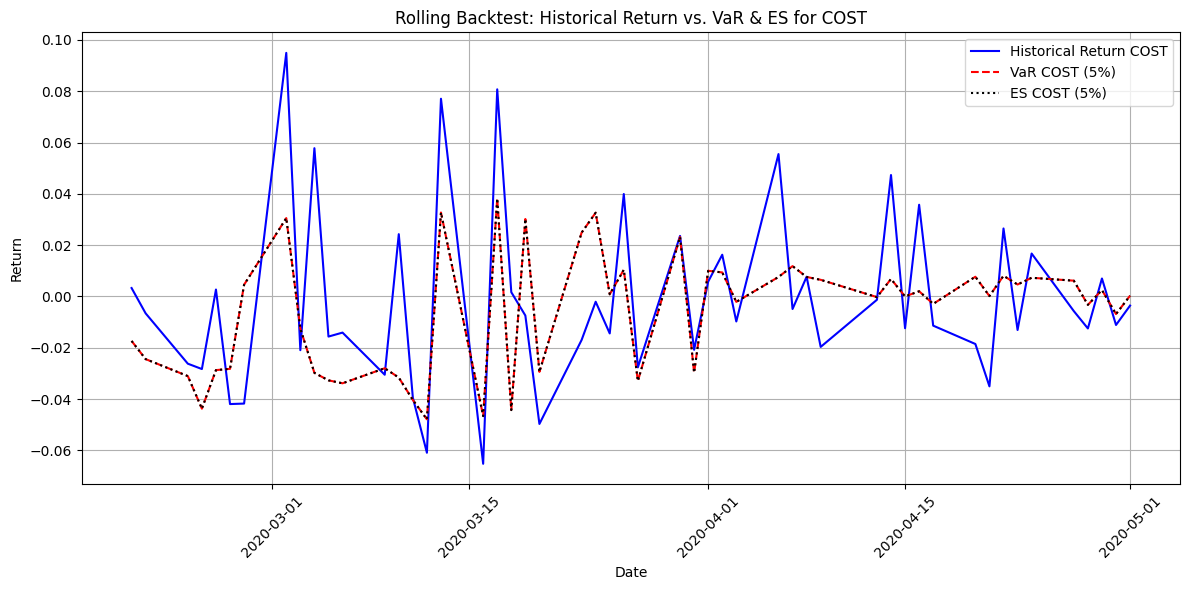

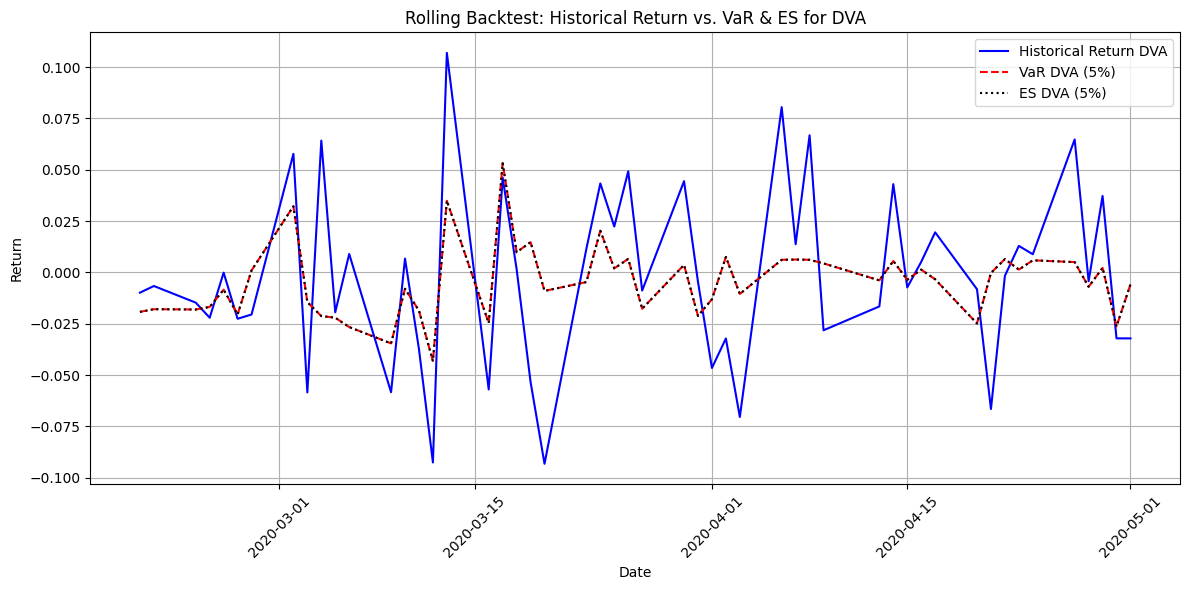

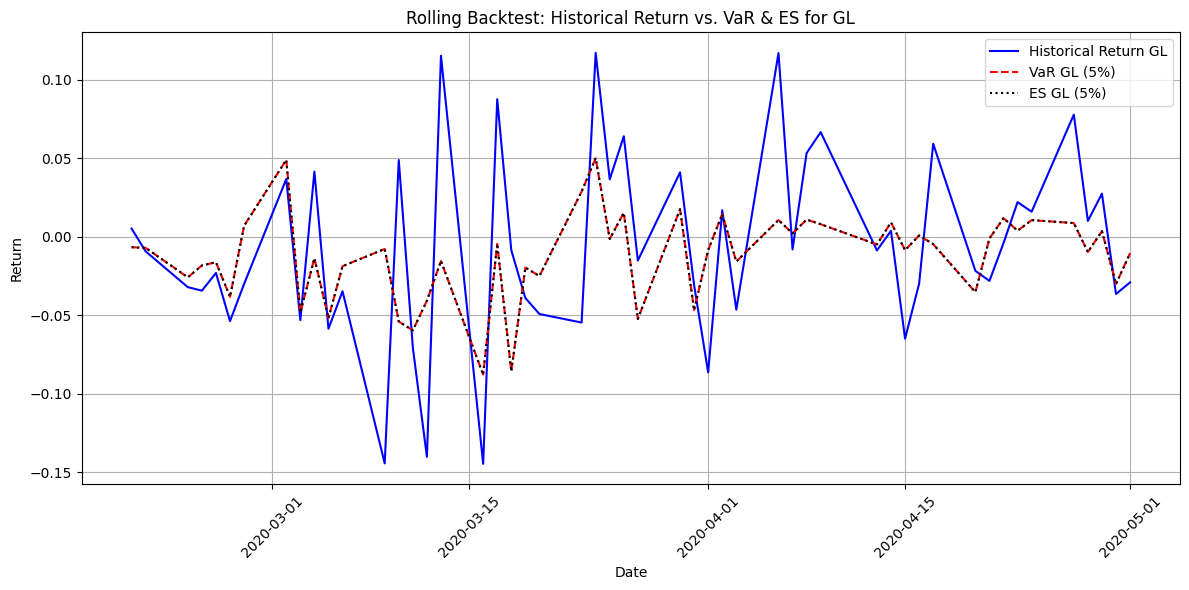

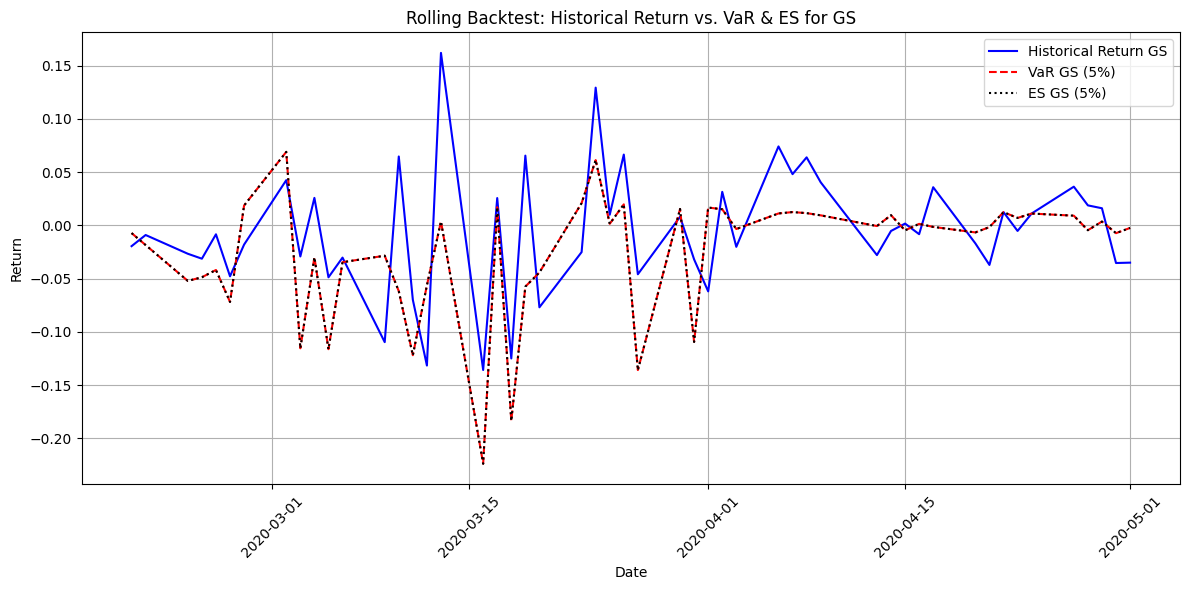

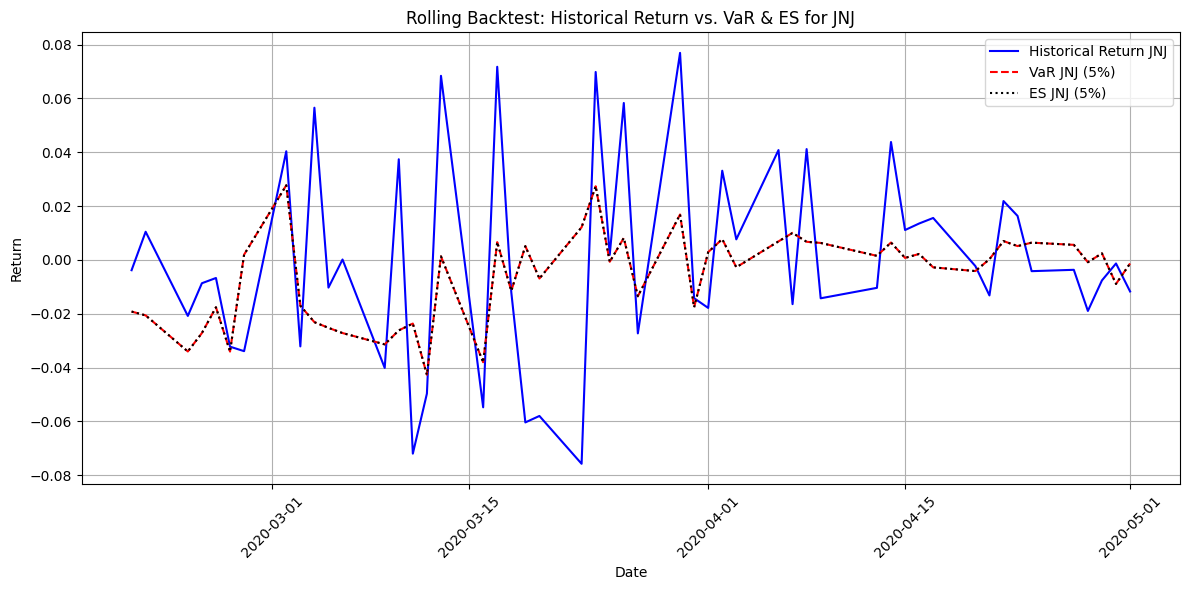

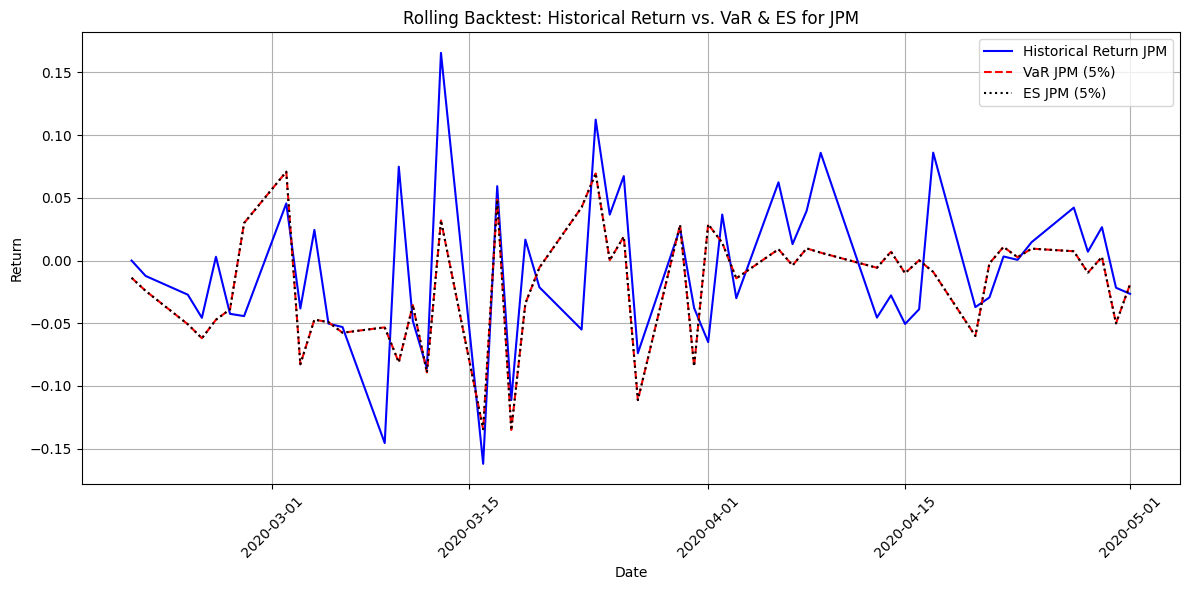

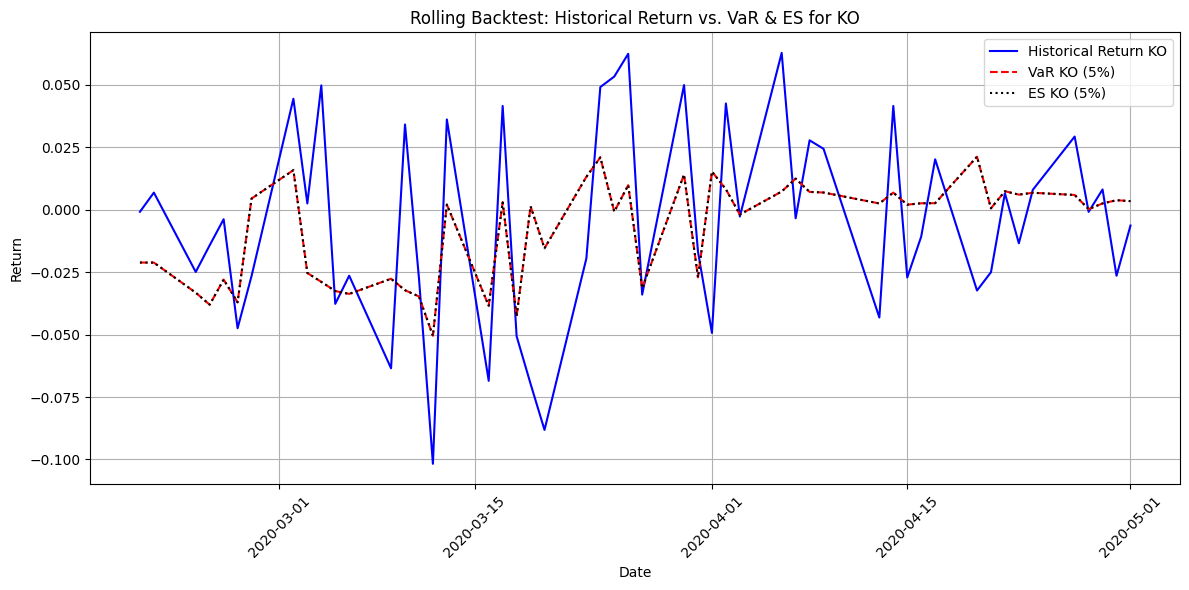

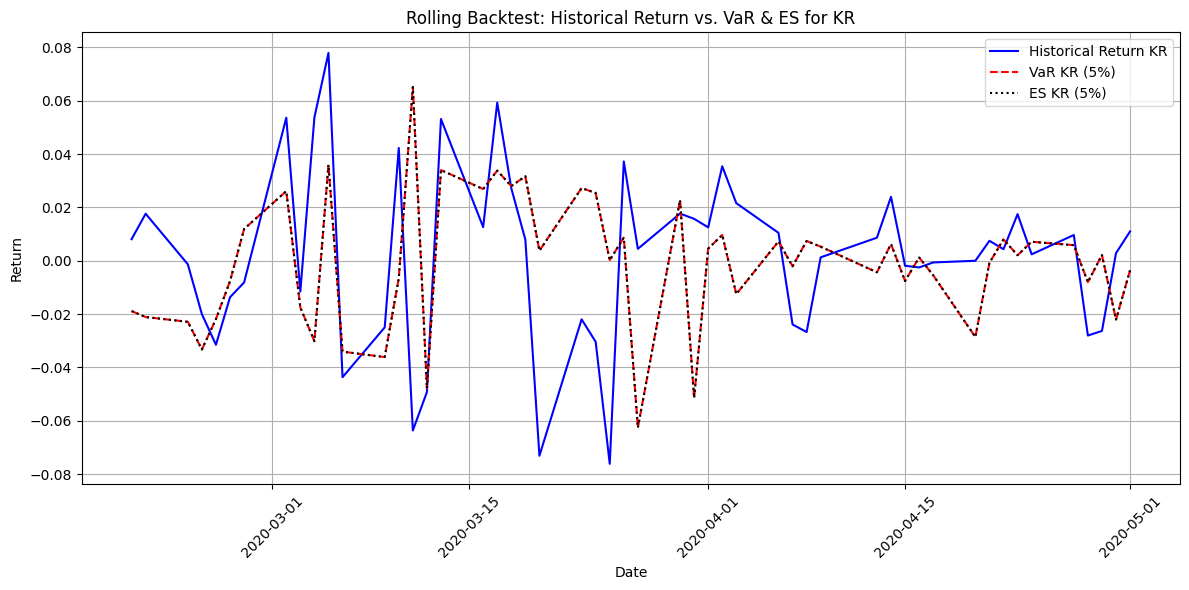

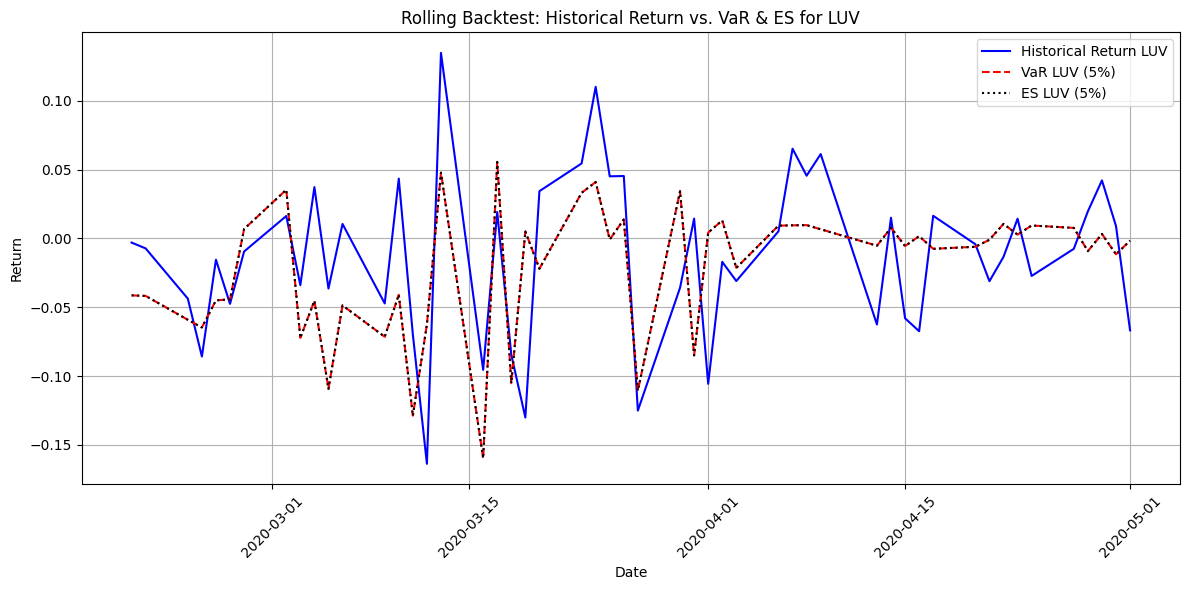

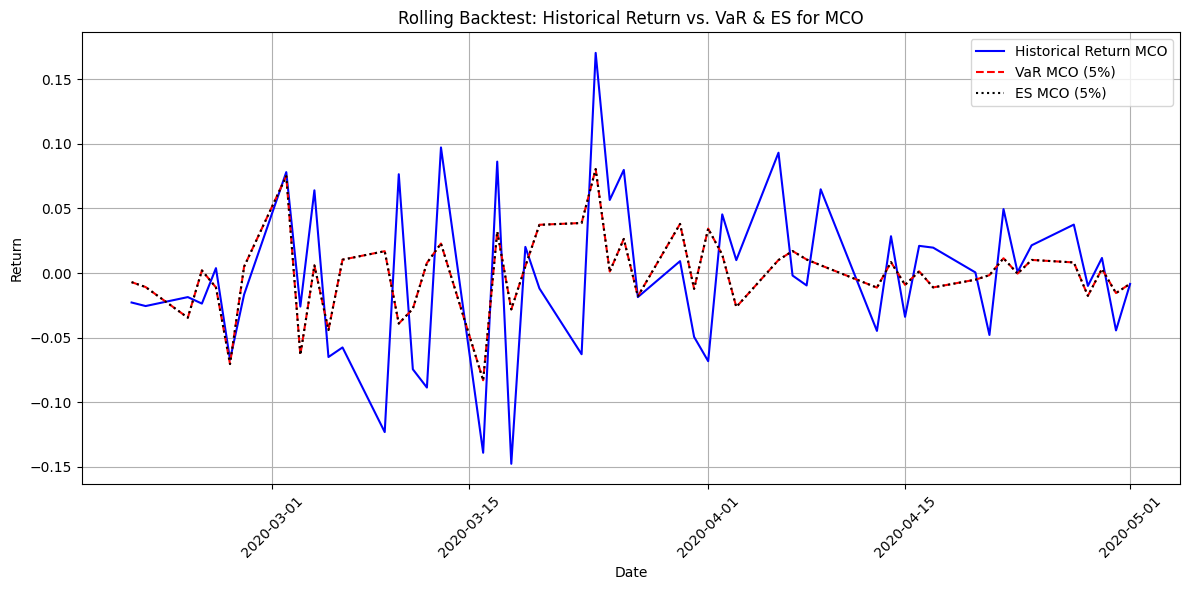

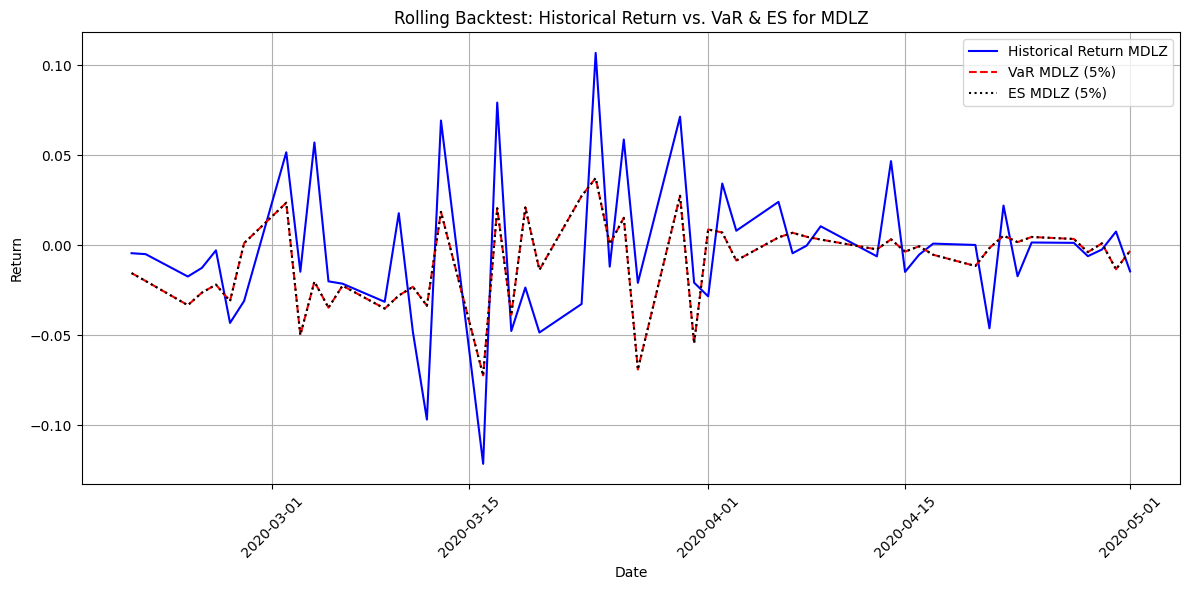

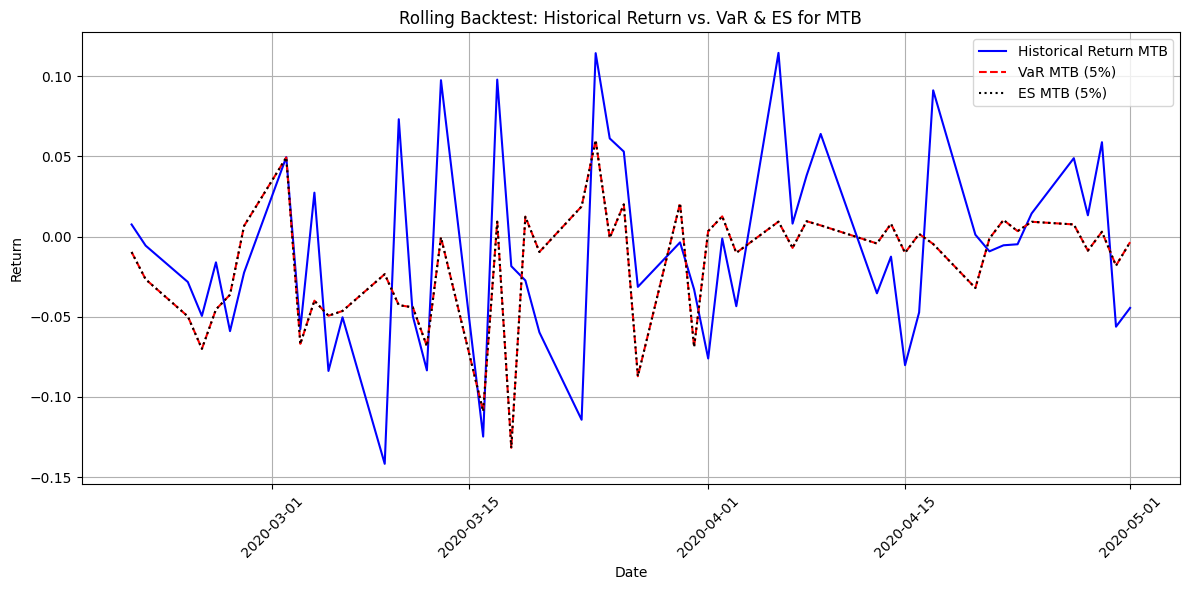

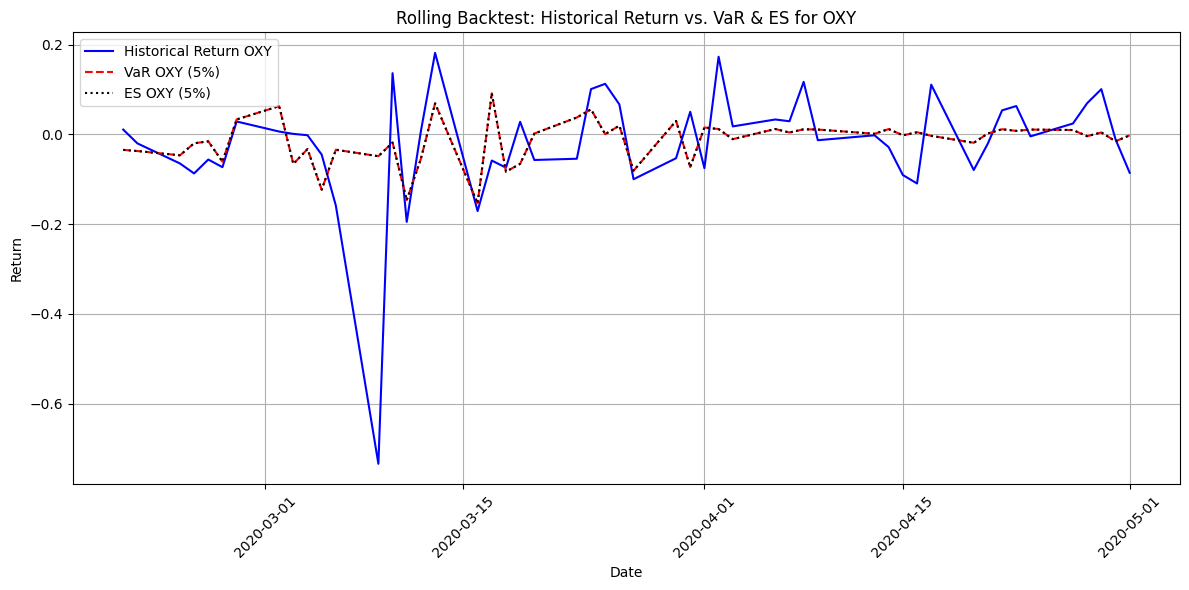

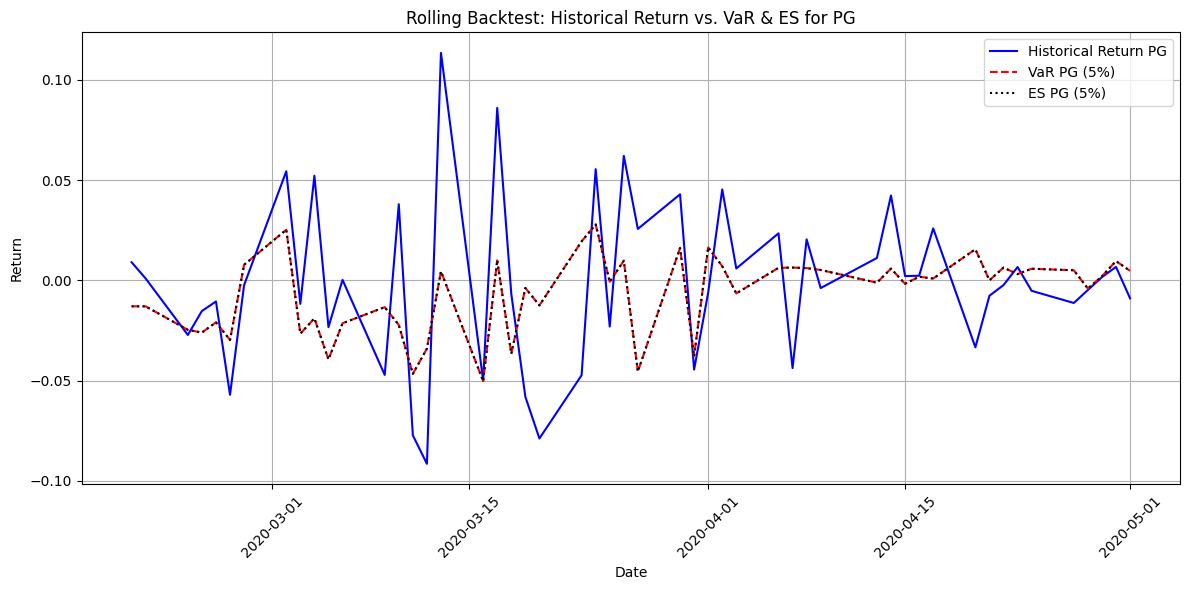

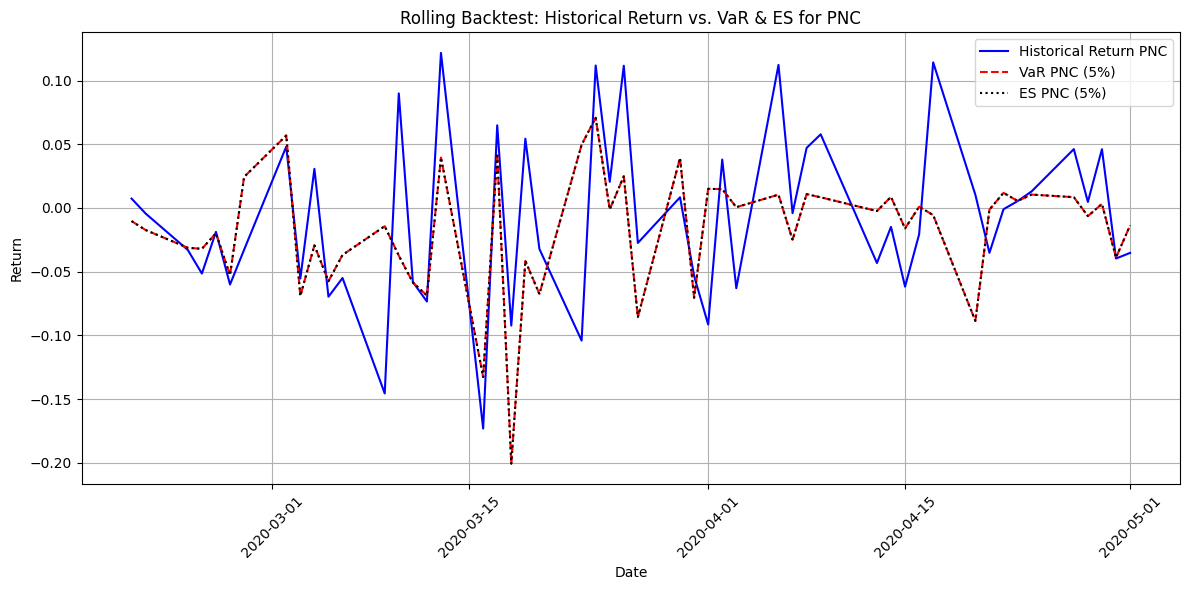

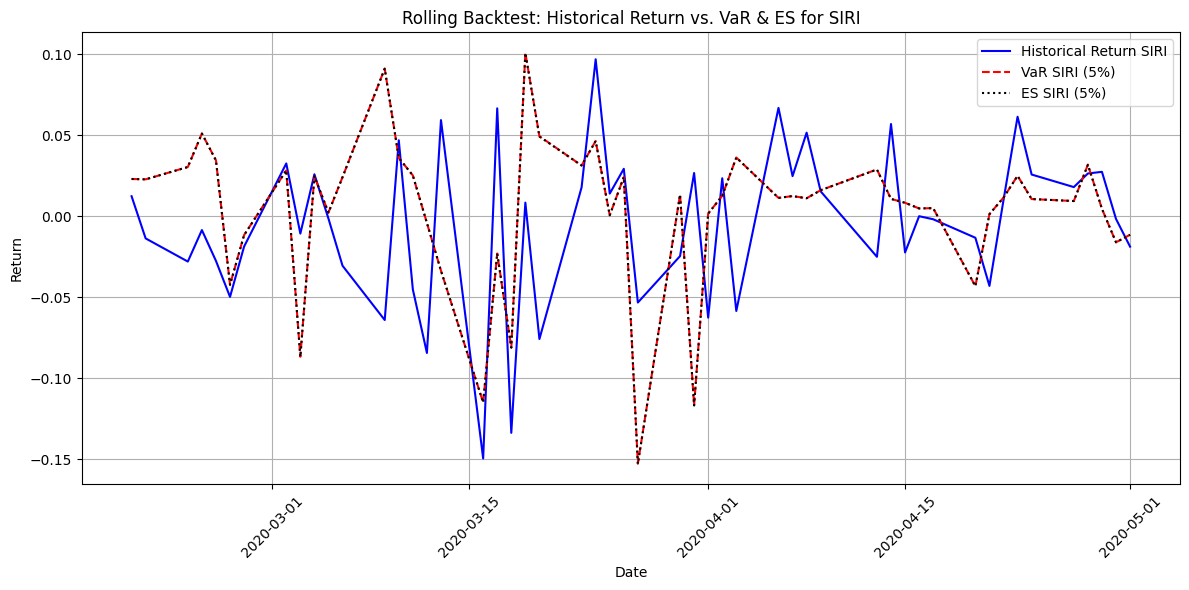

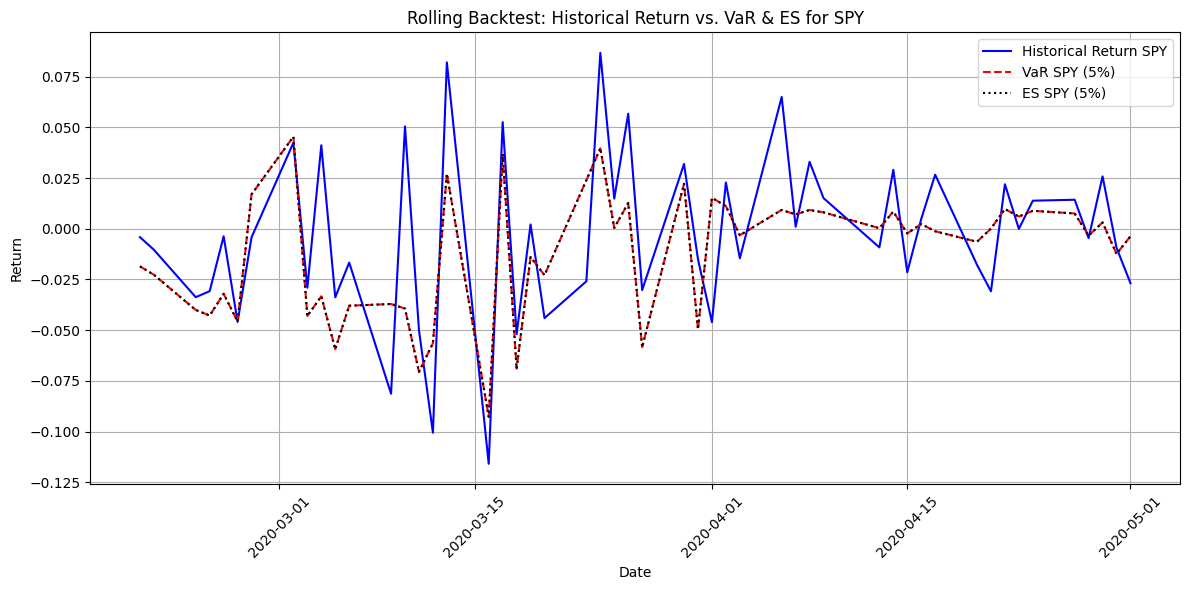

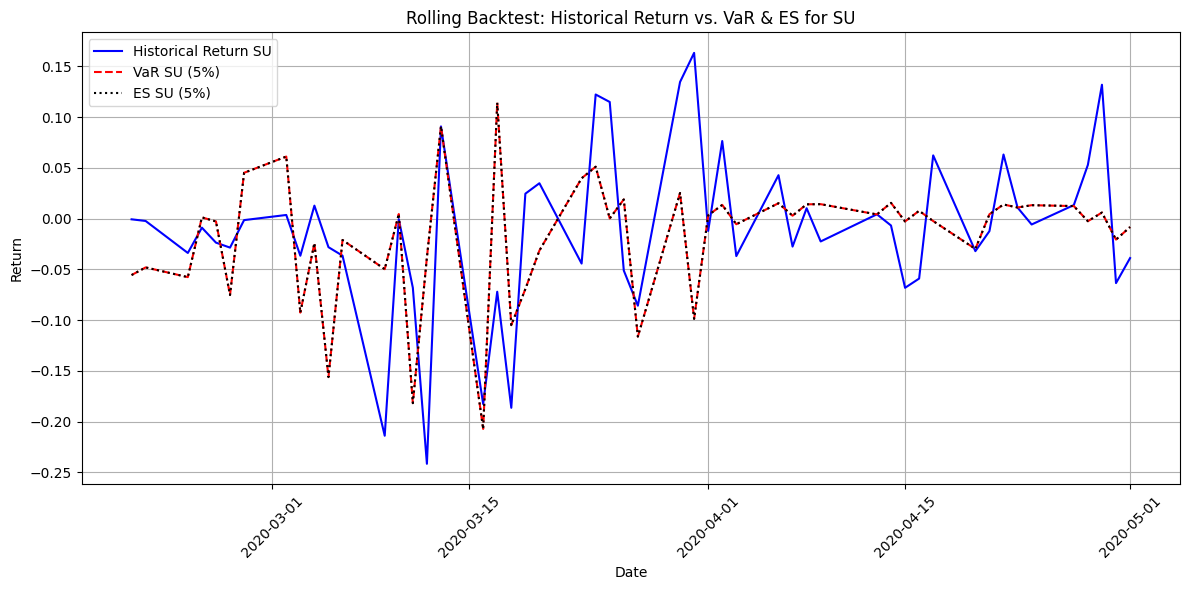

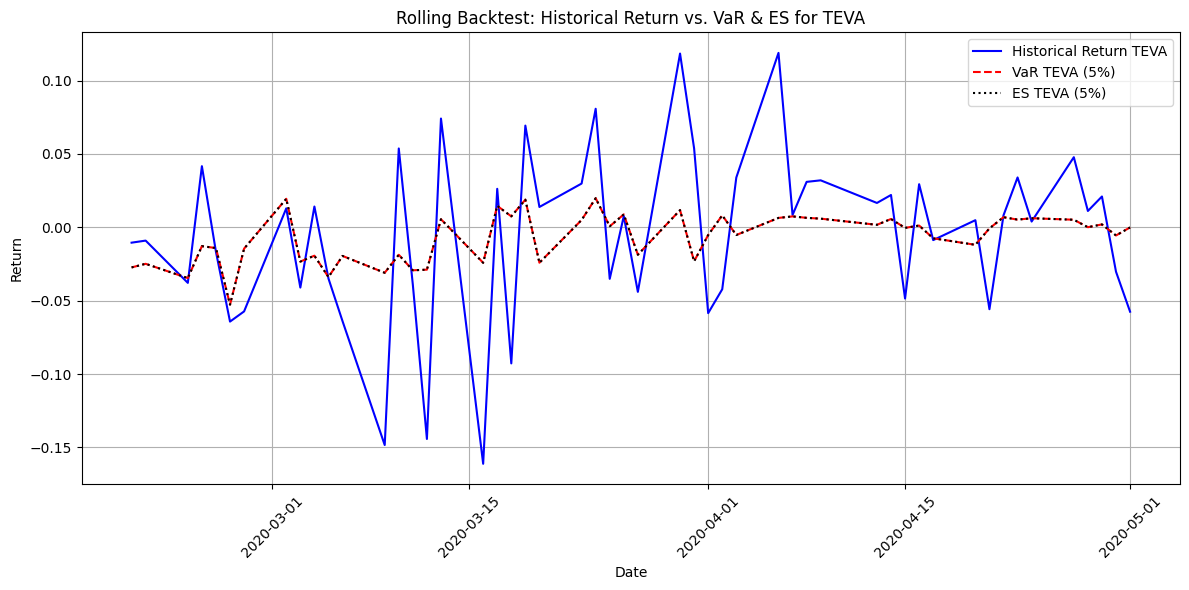

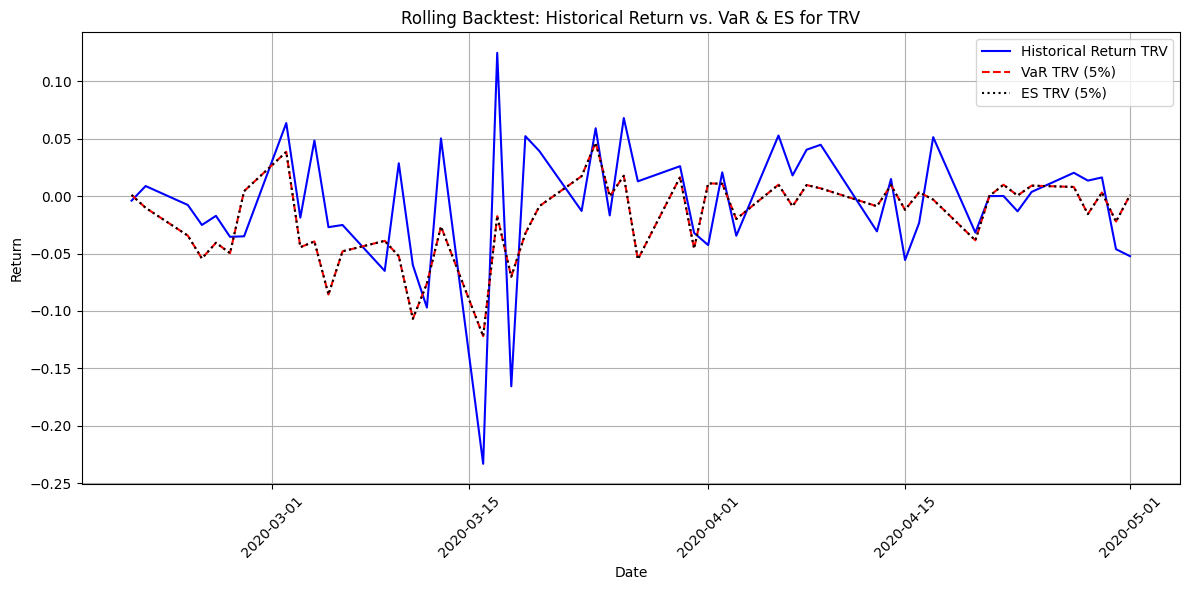

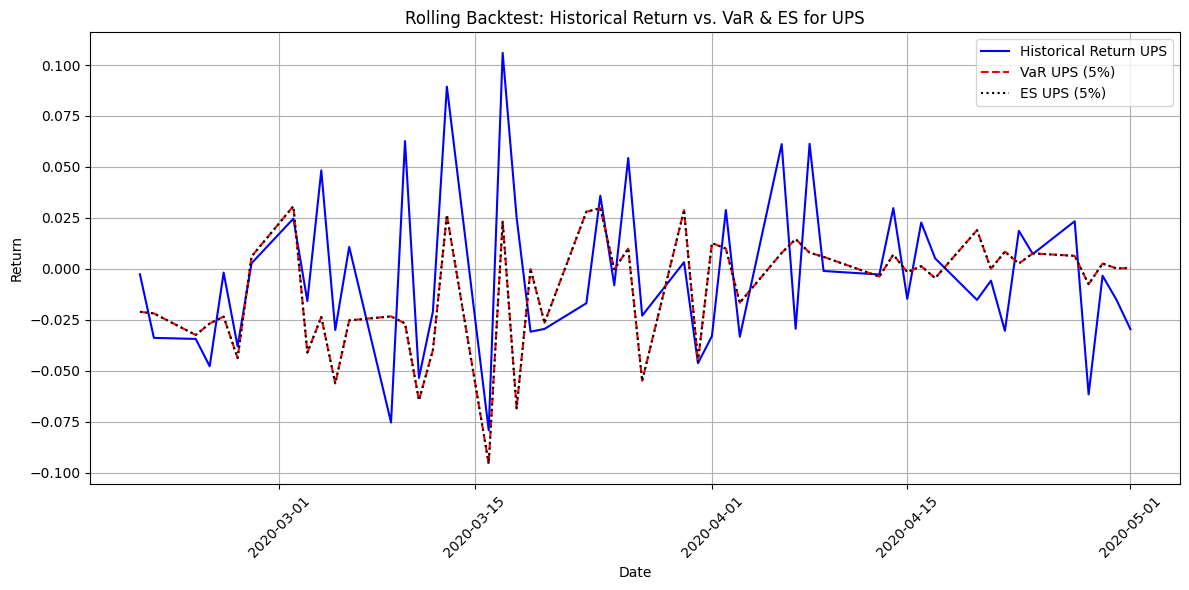

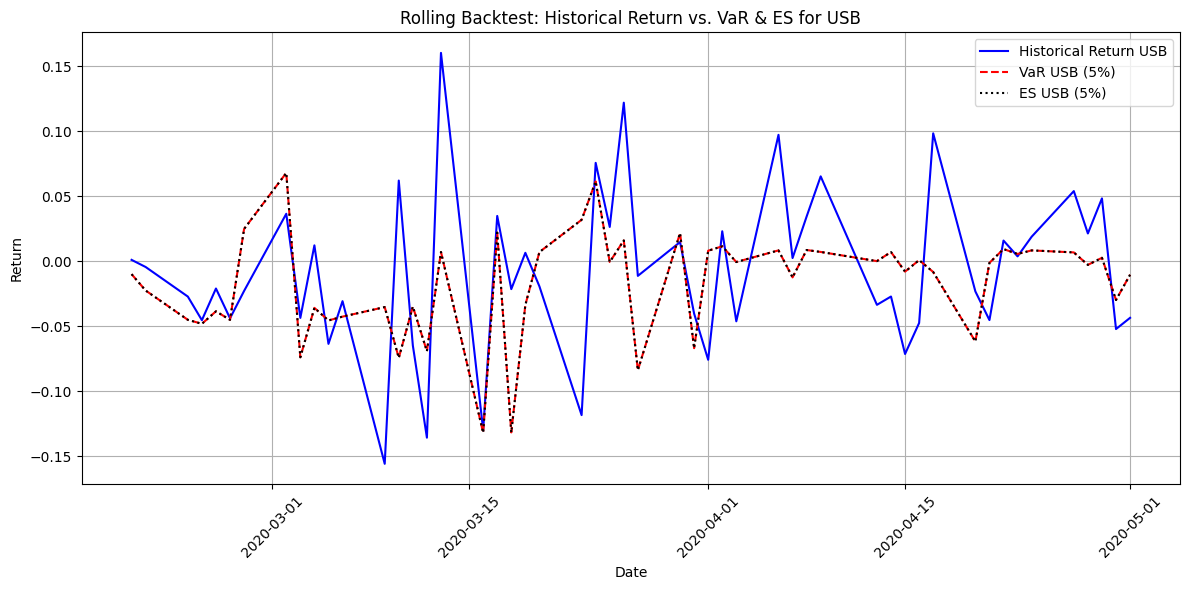

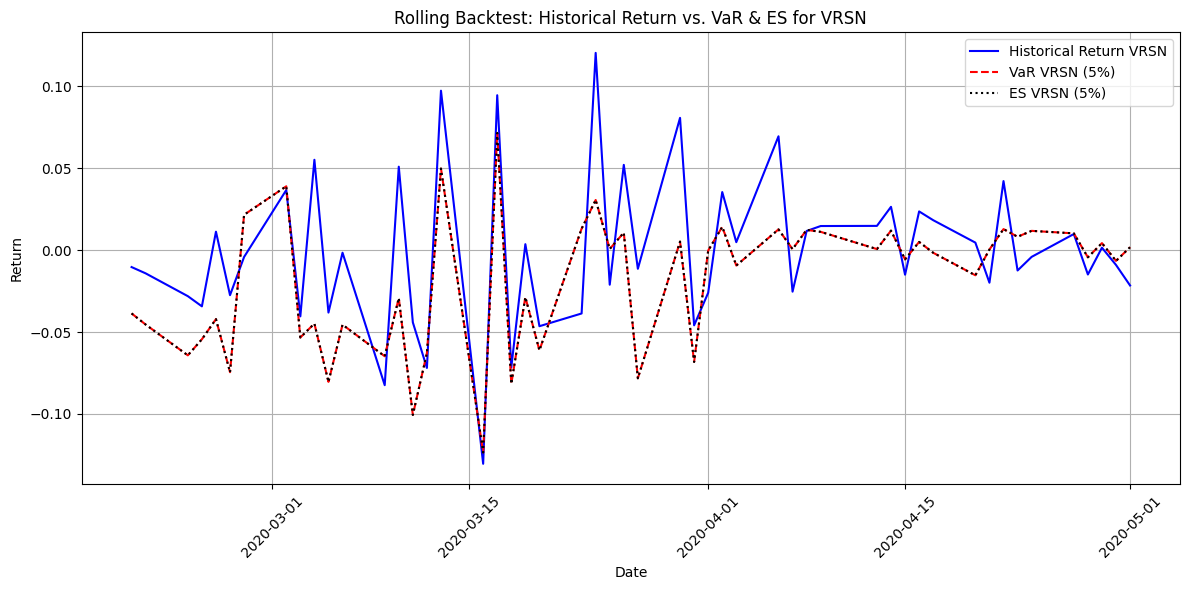

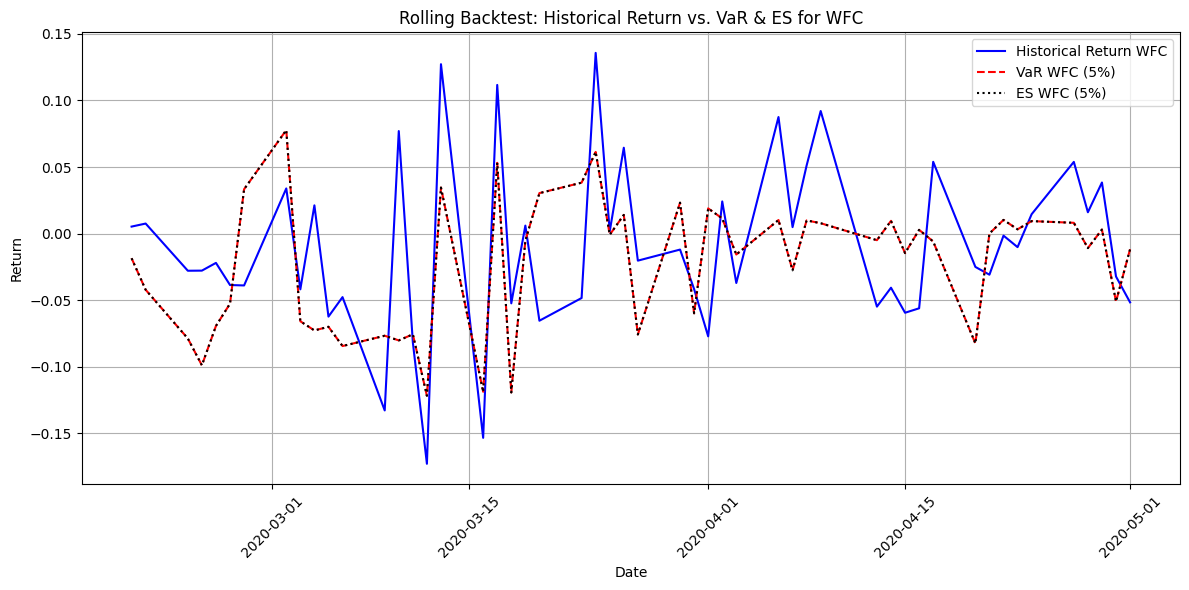

In [ ]:
for stock in returns_test.columns:
    plt.figure(figsize=(12, 6))

    # Plot historical returns
    plt.plot(backtest_df["forecast_date"], backtest_df[f"hist_return_{stock}"], label=f"Historical Return {stock}", linestyle="-", color="blue")

    # Plot synthetic VaR
    plt.plot(backtest_df["forecast_date"], backtest_df[f"synthetic_VaR_{stock}"], label=f"VaR {stock} (5%)", linestyle="--", color="red")

    # Plot synthetic Expected Shortfall
    plt.plot(backtest_df["forecast_date"], backtest_df[f"synthetic_ES_{stock}"], label=f"ES {stock} (5%)", linestyle="dotted", color="black")

    # Formatting
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.title(f"Rolling Backtest: Historical Return vs. VaR & ES for {stock}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

    # Show the plot for each stock
    plt.show()
